In [1]:
import pandas as pd
import numpy as np
import datetime
import requests
import json
import os
import time
import ftplib
from pyproj import Transformer
from datetime import datetime, timedelta
from dateutil.relativedelta import relativedelta
import matplotlib.pyplot as plt
from dotenv import load_dotenv

In [2]:
heure_debut=datetime.now().strftime('%Y-%m-%d %H:%M:%S')
dir_api = "./api/"
if not os.path.exists(dir_api):
    os.makedirs(dir_api)
dir_data = "./data/"
if not os.path.exists(dir_data):
    os.makedirs(dir_data)
dir_output = "./output/"
if not os.path.exists(dir_output):
    os.makedirs(dir_output)
dir_apiinsee = "./api/"+datetime.now().strftime('%Y%m%d')
if not os.path.exists(dir_apiinsee):
    os.makedirs(dir_apiinsee)

In [3]:
load_dotenv()
apikey = os.getenv("apikey")
inseekey = os.getenv("inseekey")
apikeyods = os.getenv("apikeyods")
ftp_HOSTNAME = os.getenv("ftp_HOSTNAME")
ftp_USERNAME = os.getenv("ftp_USERNAME")
ftp_PASSWORD = os.getenv("ftp_PASSWORD")

In [4]:
categoriesJuridiques = pd.read_excel(dir_data+'categorieJuridiqueUniteLegale.xlsx',dtype=str)
categoriesJuridiques=categoriesJuridiques[['categorieJuridiqueUniteLegale','categorieJuridiqueUniteLegaleLib']]
activitePrincipaleUniteLegale = pd.read_excel(dir_data+'activitePrincipaleUniteLegale.xlsx',dtype=str)
maj_structures_sirene_prec=pd.read_parquet(dir_data+"maj_structures_sirene_prec.parquet", engine='pyarrow')

In [5]:
les_communes=pd.read_parquet(dir_data+"les_communes.parquet", engine='pyarrow')

In [6]:
headers = {
    'Accept': 'application/json',
    'X-API-KEY': apikey,
}
try:
    response = requests.get("https://api.paysage.dataesr.ovh/identifiers?filters[type]=siret&limit=10000", headers=headers)
    response.raise_for_status()
    result = response.json()
    sirets = pd.DataFrame(result["data"])
    time.sleep(.6)
except requests.exceptions.HTTPError as errh:
    print("siret > KO : ", response.status_code)
sirets=sirets.rename(columns={"value": "siret"})
sirets["dernier_traitement"]=datetime.now().strftime('%Y-%m-%d %H:%M:%S')
sirets["url_paysage"]="https://paysage.enseignementsup-recherche.gouv.fr/structures/"+sirets["resourceId"]+"/presentation"
sirets["url_annuaire"]="https://annuaire-entreprises.data.gouv.fr/etablissement/"+sirets["siret"]
sirets["url_ods"]="https://data.enseignementsup-recherche.gouv.fr/explore/dataset/fr-esr-maj_structures_sirene/table/?sort=datedebut&refine.numero_siren="+sirets["siret"].str[:9]
les_sirets=sirets[(~sirets["siret"].isnull())]["siret"].drop_duplicates()
siret_paysage = sirets.copy()
siret_paysage["Siret_dans_paysage"] = "Oui"
siret_paysage=siret_paysage[(~siret_paysage["siret"].isnull())][["siret","Siret_dans_paysage"]].drop_duplicates()
siret_paysage=siret_paysage.rename(columns={"siret": "dern_numero_siret"})
les_sirens=les_sirets.str[:9].drop_duplicates()
les_sirens
siret_paysage2 = sirets.copy()
siret_paysage2["siren"]=siret_paysage2["siret"].str[:9]
siret_paysage2=siret_paysage2[["resourceId","siren"]].drop_duplicates()
siret_paysage2

,resourceId,siren
0,9unA5,799066618
1,zh675,390220119
2,br3Cc,538758236
3,emqo9,497511923
4,xYJ6W,879223923
...,...,...
6301,xJdyB,130015332
6302,1tI7C,191333400
6303,8tVLr,191010602
6304,7CYWd,190609313


In [7]:
siren_paysage = (siret_paysage2.pivot_table(index=['siren'], values='resourceId', aggfunc=';'.join)
            .rename_axis(columns=None)
         ).reset_index()
siren_paysage['nb'] = siren_paysage["resourceId"].str.count(';')+1
siren_paysage_unique=siren_paysage[(siren_paysage['nb']==1)]

In [8]:
headers = {
    'Accept': 'application/json',
    'X-API-KEY': apikey,
}
try:
    response = requests.get("https://api.paysage.dataesr.ovh/identifiers?filters[type]=rna&limit=10000", headers=headers)
    response.raise_for_status()
    result = response.json()
    rnas = pd.DataFrame(result["data"])
    time.sleep(.6)
except requests.exceptions.HTTPError as errh:
    print("siret > KO : ", response.status_code)
rnas=rnas.rename(columns={"value": "identifiantAssociationUniteLegale"})
rnas["Rna_dans_paysage"] = "Oui"
Rna_paysage=rnas[(~rnas["identifiantAssociationUniteLegale"].isnull())][["identifiantAssociationUniteLegale","Rna_dans_paysage"]].drop_duplicates()
Rna_paysage

,identifiantAssociationUniteLegale,Rna_dans_paysage
0,W751276301,Oui
1,W133036847,Oui
2,W353021707,Oui
3,W313004321,Oui
4,W751265632,Oui
...,...,...
196,W601001426,Oui
197,W595008501,Oui
198,W595026827,Oui
199,W543003821,Oui


In [9]:
headers = {
    'X-INSEE-Api-Key-Integration': inseekey,
}
def extract_maj_sirene(dateheure,curseur="*"):
    global i
    i=i+1
    les_sirets_modifs = pd.DataFrame(columns = ["siret","dateDernierTraitementEtablissement"])
    cursor = curseur.replace("*","-")
    dateheure2 = datetime.now()
    dateheure2 = dateheure2.isoformat()
    dateheure2 = dateheure2[:13]
    params = {
        'q': 'dateDernierTraitementEtablissement:['+dateheure+' TO '+dateheure2+']',
        'champs': 'siret,dateDernierTraitementEtablissement',
        'nombre': '1000',
        'curseur': curseur
    }
    if os.path.isfile(dir_apiinsee+"/modifs_-_"+cursor+".json"):
        f = open(dir_apiinsee+"/modifs_-_"+cursor+".json")
        result = json.load(f)
        f.close()
    else:
        response = requests.get('https://api.insee.fr/api-sirene/3.11/siret', params=params, headers=headers)
        writeFile =open(dir_apiinsee+"/modifs_-_"+cursor+".json", 'w')
        json.dump(response.json(),writeFile)
        writeFile.close()
        result = response.json()
        time.sleep(2.1)
    if result["header"]["statut"]==200:
        les_sirets_modif = pd.DataFrame(result["etablissements"])
        les_sirets_modifs = pd.concat([les_sirets_modifs, les_sirets_modif], axis=0, join='outer')
        curseurSuivant=result["header"]["curseurSuivant"]
        if curseurSuivant != curseur :
            if i==1 :
                print("Total : "+str(result["header"]["total"]))
            if i%25==0 :
                print(str(i)+"000 - "+datetime.now().strftime('%Y-%m-%d %H:%M:%S'))
            les_sirets_modif = extract_maj_sirene(dateheure,curseurSuivant)
            les_sirets_modif = pd.DataFrame(les_sirets_modif)
            les_sirets_modifs = pd.concat([les_sirets_modifs, les_sirets_modif], axis=0, join='outer')
        return les_sirets_modifs    

In [10]:
#debut = datetime.now() - relativedelta(days=6)
#fin = datetime.now() + relativedelta(hours=1)
#delta = timedelta(hours=1)
#dates = []
#while debut <= fin:
#    dates.append(debut.isoformat())
#    debut += delta
#i=0
#for date in dates:
les_sirets_modifs = pd.DataFrame(columns = ["siret","dateDernierTraitementEtablissement"])

In [11]:
i=0
les_sirets_modifs = pd.DataFrame(columns = ["siret","dateDernierTraitementEtablissement"])
dateheure = datetime.now() - relativedelta(days=10)
dateheure = dateheure.isoformat()
dateheure = dateheure[:13]
les_sirets_modif = extract_maj_sirene(dateheure)
les_sirets_modif = pd.DataFrame(les_sirets_modif)
les_sirets_modifs = pd.concat([les_sirets_modifs, les_sirets_modif], axis=0, join='outer')
les_sirets_modifs=les_sirets_modifs.drop_duplicates()
print("Terminé")

Total : 161310
25000 - 2024-12-05 14:09:17
50000 - 2024-12-05 14:09:17
75000 - 2024-12-05 14:09:17
100000 - 2024-12-05 14:09:17
125000 - 2024-12-05 14:09:17
150000 - 2024-12-05 14:09:17
Terminé


In [12]:
print(les_sirets_modifs)

              siret dateDernierTraitementEtablissement
0    00562003400032            2024-12-04T05:34:13.249
1    00648024800043            2024-12-03T10:41:38.928
2    00648024800050            2024-12-03T10:41:38.933
3    00652026600039            2024-12-04T05:34:06.253
4    00665008900037            2024-11-27T08:25:45.849
..              ...                                ...
305  99882350433176            2024-12-03T15:59:08.460
306  99889300200142            2024-11-26T17:05:49.739
307  99889300200217            2024-11-29T17:02:46.993
308  99999030200047            2024-11-26T05:31:34.206
309  99999036900095            2024-12-02T10:31:49.640

[161310 rows x 2 columns]


In [13]:
les_siretss=pd.DataFrame(les_sirets)
les_siretss=les_siretss.rename(columns={0: "siret"})
les_sirets_a_gerer=pd.merge(les_siretss,les_sirets_modifs,how='inner',on=['siret'])
les_sirets_a_gerer

,siret,dateDernierTraitementEtablissement
0,39022011900049,2024-12-02T17:16:27.771
1,53875823600052,2024-12-02T09:54:12.037
2,49751192300052,2024-12-02T10:44:40.671
3,87922392300035,2024-11-29T12:01:02.192
4,89241456600042,2024-11-28T09:26:25.153
...,...,...
69,77566410500019,2024-12-03T09:53:22.098
70,18004619500012,2024-11-28T05:25:53.003
71,19624401600016,2024-11-30T05:23:15.127
72,13001727000146,2024-11-26T05:25:13.744


In [14]:
nbfic = 0
for ind in les_sirets_a_gerer.index:
    numero_siret = les_sirets_a_gerer['siret'][ind]
    numero_siren= numero_siret[:9]
    fname = dir_api+"/"+numero_siret+".json"
    if os.path.isfile(fname):
        os.remove(fname)
        nbfic+=1
    fname = dir_api+"/"+numero_siren+".json"
    if os.path.isfile(fname):
        os.remove(fname)
        nbfic+=1
if nbfic>1:
    print(str(nbfic)+" fichier(s) json supprimé(s)")
else:
    print(str(nbfic)+" fichier json supprimé")

89 fichier(s) json supprimé(s)


In [15]:
headers = {
    'X-INSEE-Api-Key-Integration': inseekey,
}
def extract_siren(numero_siren):
    structure = {}
    structure["numero_siren"] = numero_siren
    sep=";"
    params = {
        'q': 'siren:'+numero_siren,
        'masquerValeursNulles' : 'true'
    }
    if os.path.isfile(dir_api+"/"+numero_siren+".json"):
        f = open(dir_api+"/"+numero_siren+".json")
        result = json.load(f)
        f.close()
    else:
        response = requests.get('https://api.insee.fr/api-sirene/3.11/siren', params=params, headers=headers)
        writeFile =open(dir_api+"/"+numero_siren+".json", 'w')
        json.dump(response.json(),writeFile)
        writeFile.close()
        result = response.json()
        time.sleep(2.02)
    structure["statut"] = result["header"]["statut"]
    if result["header"]["statut"]==200:
        if "unitesLegales" in result:
            if "dateCreationUniteLegale" in result["unitesLegales"][0]:
                structure["dateCreationUniteLegale"]=result["unitesLegales"][0]["dateCreationUniteLegale"]
            if "identifiantAssociationUniteLegale" in result["unitesLegales"][0]:
                structure["identifiantAssociationUniteLegale"]=result["unitesLegales"][0]["identifiantAssociationUniteLegale"]
            if "sigleUniteLegale" in result["unitesLegales"][0]:
                structure["sigleUniteLegale"]=result["unitesLegales"][0]["sigleUniteLegale"]
            if "dateDernierTraitementUniteLegale" in result["unitesLegales"][0]:
                structure["dateDernierTraitementUniteLegale"]=result["unitesLegales"][0]["dateDernierTraitementUniteLegale"]
            if "categorieEntreprise" in result["unitesLegales"][0]:
                structure["categorieEntreprise"]=result["unitesLegales"][0]["categorieEntreprise"]
            if result["unitesLegales"][0]["nombrePeriodesUniteLegale"]>0:
                if "dateDebut" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["dateDebutDerniere"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["dateDebut"]
                if "dateFin" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["dateFinDerniere"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["dateFin"]
                if "denominationUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["denominationUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["denominationUniteLegale"]
                if "nomUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["nomUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["nomUniteLegale"]
                if "nomUsageUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["nomUsageUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["nomUsageUniteLegale"]
                if "denominationUsuelle1UniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["denominationUsuelle1UniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["denominationUsuelle1UniteLegale"]
                if "denominationUsuelle2UniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["denominationUsuelle2UniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["denominationUsuelle2UniteLegale"]
                if "denominationUsuelle3UniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["denominationUsuelle3UniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["denominationUsuelle3UniteLegale"]
                if "etatAdministratifUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["etatAdministratifUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["etatAdministratifUniteLegale"]
                if "nicSiegeUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["nicSiegeUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["nicSiegeUniteLegale"]
                    structure["numero_siret"]=numero_siren+result["unitesLegales"][0]["periodesUniteLegale"][0]["nicSiegeUniteLegale"]
                if "categorieJuridiqueUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["categorieJuridiqueUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["categorieJuridiqueUniteLegale"]
                if "activitePrincipaleUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["activitePrincipaleUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["activitePrincipaleUniteLegale"]
                if "nomenclatureActivitePrincipaleUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["nomenclatureActivitePrincipaleUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["nomenclatureActivitePrincipaleUniteLegale"]
                if "changementEtatAdministratifUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["changementEtatAdministratifUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["changementEtatAdministratifUniteLegale"]
                if "changementNomUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["changementNomUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["changementNomUniteLegale"]
                if "changementNomUsageUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["changementNomUsageUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["changementNomUsageUniteLegale"]
                if "changementDenominationUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["changementDenominationUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["changementDenominationUniteLegale"]
                if "changementDenominationUsuelleUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["changementDenominationUsuelleUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["changementDenominationUsuelleUniteLegale"]
                if "changementCategorieJuridiqueUniteLegale" in result["unitesLegales"][0]["periodesUniteLegale"][0]:
                    structure["changementCategorieJuridiqueUniteLegale"]=result["unitesLegales"][0]["periodesUniteLegale"][0]["changementCategorieJuridiqueUniteLegale"]
                identifiers = pd.DataFrame(result["unitesLegales"][0]["periodesUniteLegale"])
                if identifiers["categorieJuridiqueUniteLegale"].count() > 0:
                    categoriesJuridiques=identifiers["categorieJuridiqueUniteLegale"].dropna().unique()
                    structure["categoriesJuridiques"] = sep.join(map(str, categoriesJuridiques))
                    structure["categoriesJuridiquesCompte"] = len(categoriesJuridiques)
    return structure

In [16]:
structures=pd.DataFrame(columns = ["numero_siren","dateCreationUniteLegale"])
i=0
for ind in les_sirens.index:
    numero_siren = les_sirens[ind]
    i=i+1
    if i%250==0:
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S')+" "+str(i)+"/{:0.1f} %".format(i*100/len(les_sirens.index)))
    structure = extract_siren(numero_siren)
    structure = pd.DataFrame(structure, index=[0])
    if (structures.empty) & (not structure.empty):
        structures = structure
    elif not structure.empty:
        structures = pd.concat([structures, structure], axis=0, join='outer')
print("Terminé")

2024-12-05 14:09:50 250/4.8 %
2024-12-05 14:10:05 500/9.6 %
2024-12-05 14:10:16 750/14.4 %
2024-12-05 14:10:20 1000/19.2 %
2024-12-05 14:10:24 1250/24.0 %
2024-12-05 14:10:26 1500/28.8 %
2024-12-05 14:10:27 1750/33.6 %
2024-12-05 14:10:31 2000/38.4 %
2024-12-05 14:10:44 2250/43.3 %
2024-12-05 14:10:52 2500/48.1 %
2024-12-05 14:11:04 2750/52.9 %
2024-12-05 14:11:07 3000/57.7 %
2024-12-05 14:11:24 3250/62.5 %
2024-12-05 14:11:35 3500/67.3 %
2024-12-05 14:11:42 3750/72.1 %
2024-12-05 14:11:46 4000/76.9 %
2024-12-05 14:11:55 4250/81.7 %
2024-12-05 14:12:05 4500/86.5 %
2024-12-05 14:12:18 4750/91.3 %
2024-12-05 14:12:25 5000/96.1 %
Terminé


In [17]:
structures

,numero_siren,statut,dateCreationUniteLegale,dateDernierTraitementUniteLegale,categorieEntreprise,dateDebutDerniere,denominationUniteLegale,etatAdministratifUniteLegale,nicSiegeUniteLegale,numero_siret,...,changementDenominationUsuelleUniteLegale,changementCategorieJuridiqueUniteLegale,categoriesJuridiques,categoriesJuridiquesCompte,sigleUniteLegale,identifiantAssociationUniteLegale,denominationUsuelle1UniteLegale,denominationUsuelle2UniteLegale,nomUniteLegale,nomUsageUniteLegale
0,799066618,200,2013-12-06,2024-11-22T14:05:38.802,PME,2024-11-01,E-PHY-SCIENCE,A,00031,79906661800031,...,False,False,5499;5710,2.0,NaN,NaN,NaN,NaN,NaN,NaN
0,390220119,200,1993-01-29,2024-12-02T17:16:27.790,PME,2024-11-20,SCIENCES & COMPUTERS CONSULTANTS,A,00049,39022011900049,...,False,False,5499;5710,2.0,S&CC,NaN,NaN,NaN,NaN,NaN
0,538758236,200,2011-12-12,2024-12-02T09:54:12.070,PME,2024-06-18,DRACULA TECHNOLOGIES,A,00052,53875823600052,...,False,False,5710;5499,2.0,NaN,NaN,NaN,NaN,NaN,NaN
0,497511923,200,2007-04-03,2024-12-02T10:44:40.698,PME,2024-04-01,WEATHERNEWS FRANCE,A,00052,49751192300052,...,False,False,5710;5599,2.0,NaN,NaN,NaN,NaN,NaN,NaN
0,879223923,200,2019-09-15,2024-11-29T12:01:02.196,PME,2024-10-24,SPORTSDYNAMICS,A,00035,87922392300035,...,False,False,5710,1.0,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,191700327,200,1993-01-28,2024-05-31T19:19:14.075,ETI,2018-10-15,LA ROCHELLE UNIVERSITE,A,00015,19170032700015,...,False,False,7383,1.0,NaN,NaN,NaN,NaN,NaN,NaN
0,130021330,200,2014-12-29,2024-03-22T14:26:06.001,PME,2014-12-29,COMMUNAUTE UNIVERSITES ET ETABLISSEMENTS NORMA...,A,00019,13002133000019,...,False,False,7383,1.0,COMUE,NaN,NaN,NaN,NaN,NaN
0,191333400,200,2003-10-01,2024-03-22T14:26:06.001,PME,2008-01-01,ECOLE CENTRALE DE MARSEILLE,A,00015,19133340000015,...,False,False,7383,1.0,CENTRALE MARSEILLE,NaN,NaN,NaN,NaN,NaN
0,190609313,200,1970-06-10,2024-03-22T14:26:06.001,NaN,2020-01-01,UNIVERSITE DE NICE,C,00019,19060931300019,...,False,False,7383,1.0,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
epsg = {'D001':'EPSG:2154','D002':'EPSG:2154','D003':'EPSG:2154','D004':'EPSG:2154','D005':'EPSG:2154','D006':'EPSG:2154','D007':'EPSG:2154','D008':'EPSG:2154','D009':'EPSG:2154','D010':'EPSG:2154','D011':'EPSG:2154','D012':'EPSG:2154','D013':'EPSG:2154','D014':'EPSG:2154','D015':'EPSG:2154','D016':'EPSG:2154','D017':'EPSG:2154','D018':'EPSG:2154','D019':'EPSG:2154','D021':'EPSG:2154','D022':'EPSG:2154','D023':'EPSG:2154','D024':'EPSG:2154','D025':'EPSG:2154','D026':'EPSG:2154','D027':'EPSG:2154','D028':'EPSG:2154','D029':'EPSG:2154','D02A':'EPSG:2154','D02B':'EPSG:2154','D030':'EPSG:2154','D031':'EPSG:2154','D032':'EPSG:2154','D033':'EPSG:2154','D034':'EPSG:2154','D035':'EPSG:2154','D036':'EPSG:2154','D037':'EPSG:2154','D038':'EPSG:2154','D039':'EPSG:2154','D040':'EPSG:2154','D041':'EPSG:2154','D042':'EPSG:2154','D043':'EPSG:2154','D044':'EPSG:2154','D045':'EPSG:2154','D046':'EPSG:2154','D047':'EPSG:2154','D048':'EPSG:2154','D049':'EPSG:2154','D050':'EPSG:2154','D051':'EPSG:2154','D052':'EPSG:2154','D053':'EPSG:2154','D054':'EPSG:2154','D055':'EPSG:2154','D056':'EPSG:2154','D057':'EPSG:2154','D058':'EPSG:2154','D059':'EPSG:2154','D060':'EPSG:2154','D061':'EPSG:2154','D062':'EPSG:2154','D063':'EPSG:2154','D064':'EPSG:2154','D065':'EPSG:2154','D066':'EPSG:2154','D067':'EPSG:2154','D068':'EPSG:2154','D069':'EPSG:2154','D070':'EPSG:2154','D071':'EPSG:2154','D072':'EPSG:2154','D073':'EPSG:2154','D074':'EPSG:2154','D075':'EPSG:2154','D076':'EPSG:2154','D077':'EPSG:2154','D078':'EPSG:2154','D079':'EPSG:2154','D080':'EPSG:2154','D081':'EPSG:2154','D082':'EPSG:2154','D083':'EPSG:2154','D084':'EPSG:2154','D085':'EPSG:2154','D086':'EPSG:2154','D087':'EPSG:2154','D088':'EPSG:2154','D089':'EPSG:2154','D090':'EPSG:2154','D091':'EPSG:2154','D092':'EPSG:2154','D093':'EPSG:2154','D094':'EPSG:2154','D095':'EPSG:2154','D971':'EPSG:5490','D972':'EPSG:5490','D973':'EPSG:2972','D974':'EPSG:2975','D975':'EPSG:4467','D976':'EPSG:4471','D978':'EPSG:5490','D986':'EPSG:8903','D987':'EPSG:6687','D988':'EPSG:3163'}
les_communes2=les_communes[(les_communes["reg_id"]!="R99")][["com_code","dep_id"]].rename(columns={"com_code": "codeCommuneEtablissement","dep_id": "epsg"}).drop_duplicates(subset=['codeCommuneEtablissement'])
les_communes2=les_communes2.replace({"epsg": epsg})

In [19]:
les_sirets= pd.concat([les_sirets, structures["numero_siret"].drop_duplicates()], axis=0, join='outer').drop_duplicates().reset_index()
les_sirets=les_sirets[(~les_sirets[0].isnull())][[0]].drop_duplicates()
les_sirets

,0
0,79906661800031
1,39022011900049
2,53875823600052
3,49751192300052
4,87922392300035
...,...
6428,78461701100027
6429,78475641300117
6430,75080177100023
6431,18640005700011


In [20]:
headers = {
    'X-INSEE-Api-Key-Integration': inseekey,
}
def extract_data_siret(numero_siret):
    structure = {}
    numero_siren = numero_siret[:9]
    structure["siren"] = numero_siren
    structure["siret"] = numero_siret
    sep=";"
    params = {
        'q': 'siret:'+numero_siret,
        'masquerValeursNulles' : 'true'
    }
    if os.path.isfile(dir_api+"/"+numero_siret+".json"):
        f = open(dir_api+"/"+numero_siret+".json")
        result = json.load(f)
        f.close()
    else:
        response = requests.get('https://api.insee.fr/api-sirene/3.11/siret', params=params, headers=headers)
        #response.raise_for_status()
        writeFile =open(dir_api+"/"+numero_siret+".json", 'w')
        json.dump(response.json(),writeFile)
        writeFile.close()
        result = response.json()
        time.sleep(2.02)
    structure["statut"] = result["header"]["statut"]
    structure["message"] = result["header"]["message"]
    if result["header"]["statut"]==200:
        if "etablissements" in result:
            if "etablissementSiege" in result["etablissements"][0]:
                structure["etablissementSiege"]=result["etablissements"][0]["etablissementSiege"]            
            if "dateCreationEtablissement" in result["etablissements"][0]:
                structure["dateCreationEtablissement"]=result["etablissements"][0]["dateCreationEtablissement"]            
            if "dateDernierTraitementEtablissement" in result["etablissements"][0]:
                structure["dateDernierTraitementEtablissement"]=result["etablissements"][0]["dateDernierTraitementEtablissement"]            
            if "uniteLegale" in result["etablissements"][0]:
                if "etatAdministratifUniteLegale" in result["etablissements"][0]["uniteLegale"]:
                    structure["etatAdministratifUniteLegale"]=result["etablissements"][0]["uniteLegale"]["etatAdministratifUniteLegale"]            
                if "dateCreationUniteLegale" in result["etablissements"][0]["uniteLegale"]:
                    structure["dateCreationUniteLegale"]=result["etablissements"][0]["uniteLegale"]["dateCreationUniteLegale"]            
                if "nicSiegeUniteLegale" in result["etablissements"][0]["uniteLegale"]:
                    structure["siretSiege"]=numero_siren+result["etablissements"][0]["uniteLegale"]["nicSiegeUniteLegale"]
                if "sigleUniteLegale" in result["etablissements"][0]["uniteLegale"]:
                    structure["sigleUniteLegale"]=result["etablissements"][0]["uniteLegale"]["sigleUniteLegale"]            
                if "denominationUniteLegale" in result["etablissements"][0]["uniteLegale"]:
                    structure["denominationUniteLegale"]=result["etablissements"][0]["uniteLegale"]["denominationUniteLegale"]            
                if "categorieJuridiqueUniteLegale" in result["etablissements"][0]["uniteLegale"]:
                    structure["categorieJuridiqueUniteLegale"]=result["etablissements"][0]["uniteLegale"]["categorieJuridiqueUniteLegale"]            
            if "adresseEtablissement" in result["etablissements"][0]:
                if "numeroVoieEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["numeroVoieEtablissement"]=str(result["etablissements"][0]["adresseEtablissement"]["numeroVoieEtablissement"])
                if "dernierNumeroVoieEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["dernierNumeroVoieEtablissement"]=str(result["etablissements"][0]["adresseEtablissement"]["dernierNumeroVoieEtablissement"])
                if "typeVoieEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["typeVoieEtablissement"]=result["etablissements"][0]["adresseEtablissement"]["typeVoieEtablissement"]            
                if "libelleVoieEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["libelleVoieEtablissement"]=result["etablissements"][0]["adresseEtablissement"]["libelleVoieEtablissement"]            
                if "complementAdresseEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["complementAdresseEtablissement"]=result["etablissements"][0]["adresseEtablissement"]["complementAdresseEtablissement"]            
                if "codePostalEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["codePostalEtablissement"]=str(result["etablissements"][0]["adresseEtablissement"]["codePostalEtablissement"])
                if "libelleCommuneEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["libelleCommuneEtablissement"]=result["etablissements"][0]["adresseEtablissement"]["libelleCommuneEtablissement"]            
                if "codePaysEtrangerEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["codePaysEtrangerEtablissement"]=str(result["etablissements"][0]["adresseEtablissement"]["codePaysEtrangerEtablissement"])
                if "libellePaysEtrangerEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["libellePaysEtrangerEtablissement"]=result["etablissements"][0]["adresseEtablissement"]["libellePaysEtrangerEtablissement"]            
                if "libelleCommuneEtrangerEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["libelleCommuneEtrangerEtablissement"]=result["etablissements"][0]["adresseEtablissement"]["libelleCommuneEtrangerEtablissement"]            
                if "coordonneeLambertAbscisseEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["coordonneeEtablissement"]=result["etablissements"][0]["adresseEtablissement"]["coordonneeLambertAbscisseEtablissement"]+","+result["etablissements"][0]["adresseEtablissement"]["coordonneeLambertOrdonneeEtablissement"]
                if "identifiantAdresseEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["identifiantAdresseEtablissement"]=result["etablissements"][0]["adresseEtablissement"]["identifiantAdresseEtablissement"]            
                if "codeCommuneEtablissement" in result["etablissements"][0]["adresseEtablissement"]:
                    structure["codeCommuneEtablissement"]=result["etablissements"][0]["adresseEtablissement"]["codeCommuneEtablissement"]            
            if "periodesEtablissement" in result["etablissements"][0]:
                if "dateDebut" in result["etablissements"][0]["periodesEtablissement"]:
                    structure["dateDebut"]=result["etablissements"][0]["periodesEtablissement"][0]["dateDebut"]
                if "etatAdministratifEtablissement" in result["etablissements"][0]["periodesEtablissement"]:
                    structure["etatAdministratifEtablissement"]=result["etablissements"][0]["periodesEtablissement"][0]["etatAdministratifEtablissement"]            
                if "changementDenominationUsuelleEtablissement" in result["etablissements"][0]["periodesEtablissement"]:
                    structure["changementDenominationUsuelleEtablissement"]=result["etablissements"][0]["changementDenominationUsuelleEtablissement"][0]["etatAdministratifUniteLegale"]            
                if "changementEnseigneEtablissement" in result["etablissements"][0]["periodesEtablissement"]:
                    structure["changementEnseigneEtablissement"]=result["etablissements"][0]["periodesEtablissement"][0]["changementEnseigneEtablissement"]            
                if "changementEtatAdministratifEtablissement" in result["etablissements"][0]["periodesEtablissement"]:
                    structure["changementEtatAdministratifEtablissement"]=result["etablissements"][0]["periodesEtablissement"][0]["changementEtatAdministratifEtablissement"]            
    return structure

In [21]:
numero_siret

'19941111700013'

In [22]:
structures=pd.DataFrame(columns = ["siren","siretSiege","siret"])
i=0
for ind in les_sirets.index:
    numero_siret = les_sirets[0][ind]
    if i%250==0:
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S')+" "+str(i)+"/{:0.1f} %".format(i*100/len(les_sirets.index)))
    i=i+1
    structure = extract_data_siret(numero_siret)
    structure = pd.DataFrame(structure, index=[0])
    if (structures.empty) & (not structure.empty):
        structures = structure
    elif not structure.empty:
        structures = pd.concat([structures, structure], axis=0, join='outer')
print("Terminé")

2024-12-05 14:12:28 0/0.0 %
2024-12-05 14:12:57 250/3.9 %
2024-12-05 14:13:11 500/7.8 %
2024-12-05 14:13:21 750/11.7 %
2024-12-05 14:17:45 1000/15.5 %
2024-12-05 14:26:40 1250/19.4 %
2024-12-05 14:35:37 1500/23.3 %
2024-12-05 14:44:34 1750/27.2 %
2024-12-05 14:53:32 2000/31.1 %
2024-12-05 15:02:13 2250/35.0 %
2024-12-05 15:10:52 2500/38.9 %
2024-12-05 15:19:31 2750/42.8 %
2024-12-05 15:28:17 3000/46.6 %
2024-12-05 15:37:15 3250/50.5 %
2024-12-05 15:46:09 3500/54.4 %
2024-12-05 15:55:06 3750/58.3 %
2024-12-05 16:04:02 4000/62.2 %
2024-12-05 16:12:49 4250/66.1 %
2024-12-05 16:21:29 4500/70.0 %
2024-12-05 16:30:09 4750/73.8 %
2024-12-05 16:38:52 5000/77.7 %
2024-12-05 16:47:46 5250/81.6 %
2024-12-05 16:56:39 5500/85.5 %
2024-12-05 17:05:33 5750/89.4 %
2024-12-05 17:14:16 6000/93.3 %
2024-12-05 17:22:55 6250/97.2 %
Terminé


In [23]:
dateDernierTraitementEtablissement=structures[['siren','dateDernierTraitementEtablissement']].drop_duplicates("siren")
dateDernierTraitementEtablissement=dateDernierTraitementEtablissement.rename(columns={"siren": "numero_siren"})
structures

,siren,siret,statut,message,etablissementSiege,dateCreationEtablissement,dateDernierTraitementEtablissement,etatAdministratifUniteLegale,dateCreationUniteLegale,siretSiege,...,codePostalEtablissement,libelleCommuneEtablissement,coordonneeEtablissement,identifiantAdresseEtablissement,codeCommuneEtablissement,sigleUniteLegale,dernierNumeroVoieEtablissement,codePaysEtrangerEtablissement,libellePaysEtrangerEtablissement,libelleCommuneEtrangerEtablissement
0,799066618,79906661800031,200,OK,True,2024-07-05,2024-11-22T14:05:38.787,A,2013-12-06,79906661800031,...,06560,VALBONNE,"1026678.52,6287833.97",061520195_B,06152,NaN,NaN,NaN,NaN,NaN
0,390220119,39022011900049,200,OK,True,2024-11-20,2024-12-02T17:16:27.771,A,1993-01-29,39022011900049,...,42000,SAINT-ETIENNE,"809126.6,6485172.25",422188363_B,42218,S&CC,NaN,NaN,NaN,NaN
0,538758236,53875823600052,200,OK,True,2024-06-18,2024-12-02T09:54:12.037,A,2011-12-12,53875823600052,...,26000,VALENCE,"852216.75,6427376.99",263622842_B,26362,NaN,NaN,NaN,NaN,NaN
0,497511923,49751192300052,200,OK,True,2024-04-01,2024-12-02T10:44:40.671,A,2007-04-03,49751192300052,...,75009,PARIS,"651026.51,6864090.79",751091949_B,75109,NaN,41,NaN,NaN,NaN
0,879223923,87922392300035,200,OK,True,2024-10-24,2024-11-29T12:01:02.192,A,2019-09-15,87922392300035,...,94160,SAINT-MANDE,"657247.81,6860728.93",940674137_B,94067,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,784617011,78461701100027,200,OK,True,1989-08-01,2024-03-30T11:35:14.175,A,1900-01-01,78461701100027,...,75016,PARIS,"648128.4925053681,6863452.043919901",751165336_B,75116,CHEC,NaN,NaN,NaN,NaN
0,784756413,78475641300117,200,OK,True,1992-09-01,2024-03-30T12:24:38.895,A,1900-01-01,78475641300117,...,93420,VILLEPINTE,"663788.9003225574,6874780.164699845",930781367_B,93078,IS,NaN,NaN,NaN,NaN
0,750801771,75080177100023,200,OK,True,2022-07-01,2024-03-30T00:35:39.567,A,2012-03-07,75080177100023,...,44340,BOUGUENAIS,"352314.6186480904,6683114.7737259",440201993_B,44020,NaN,NaN,NaN,NaN,NaN
0,186400057,18640005700011,200,OK,True,1983-09-27,2024-03-30T18:41:10.472,A,1948-06-14,18640005700011,...,64100,BAYONNE,"337008.8151680981,6276964.080286231",641020065_B,64102,CCI,NaN,NaN,NaN,NaN


In [24]:
structures=pd.merge(structures,les_communes2,how='left',on='codeCommuneEtablissement')

In [25]:
coordonneeEtablissement=structures[(~structures["coordonneeEtablissement"].isnull())&(structures["coordonneeEtablissement"]!="[ND],[ND]")][["siret","epsg","coordonneeEtablissement"]]
coordonneeEtablissement[['X', 'Y']] = coordonneeEtablissement['coordonneeEtablissement'].str.split(',', n=1, expand=True)
coordonneeEtablissement

,siret,epsg,coordonneeEtablissement,X,Y
0,79906661800031,EPSG:2154,"1026678.52,6287833.97",1026678.52,6287833.97
1,39022011900049,EPSG:2154,"809126.6,6485172.25",809126.6,6485172.25
2,53875823600052,EPSG:2154,"852216.75,6427376.99",852216.75,6427376.99
3,49751192300052,EPSG:2154,"651026.51,6864090.79",651026.51,6864090.79
4,87922392300035,EPSG:2154,"657247.81,6860728.93",657247.81,6860728.93
...,...,...,...,...,...
6427,78461701100027,EPSG:2154,"648128.4925053681,6863452.043919901",648128.4925053681,6863452.043919901
6428,78475641300117,EPSG:2154,"663788.9003225574,6874780.164699845",663788.9003225574,6874780.164699845
6429,75080177100023,EPSG:2154,"352314.6186480904,6683114.7737259",352314.6186480904,6683114.7737259
6430,18640005700011,EPSG:2154,"337008.8151680981,6276964.080286231",337008.8151680981,6276964.080286231


In [26]:
selection=(coordonneeEtablissement["X"].astype(float) < 1000) & (coordonneeEtablissement["Y"].astype(float) < 1000)
coordonneeEtablissement.loc[selection, 'epsg']="EPSG:4326"
coordonneeEtablissement

,siret,epsg,coordonneeEtablissement,X,Y
0,79906661800031,EPSG:2154,"1026678.52,6287833.97",1026678.52,6287833.97
1,39022011900049,EPSG:2154,"809126.6,6485172.25",809126.6,6485172.25
2,53875823600052,EPSG:2154,"852216.75,6427376.99",852216.75,6427376.99
3,49751192300052,EPSG:2154,"651026.51,6864090.79",651026.51,6864090.79
4,87922392300035,EPSG:2154,"657247.81,6860728.93",657247.81,6860728.93
...,...,...,...,...,...
6427,78461701100027,EPSG:2154,"648128.4925053681,6863452.043919901",648128.4925053681,6863452.043919901
6428,78475641300117,EPSG:2154,"663788.9003225574,6874780.164699845",663788.9003225574,6874780.164699845
6429,75080177100023,EPSG:2154,"352314.6186480904,6683114.7737259",352314.6186480904,6683114.7737259
6430,18640005700011,EPSG:2154,"337008.8151680981,6276964.080286231",337008.8151680981,6276964.080286231


In [27]:
coordonneeEtablissement["epsg"].drop_duplicates()

0       EPSG:2154
7       EPSG:5490
30      EPSG:2975
643     EPSG:2972
2759          NaN
5590    EPSG:4471
Name: epsg, dtype: object

In [31]:
coordonneeEtablissement[(coordonneeEtablissement["epsg"].isnull())][["siret","epsg"]]

,siret,epsg
2759,20001281300065,NaN
2824,13000215700027,NaN
4206,20001281300016,NaN
6143,13000322100012,NaN


In [32]:
def convertGPS(dftemp,epsg):
    df=dftemp.copy()
    xx, yy = Transformer.from_crs(epsg,"EPSG:4326",always_xy=True).transform(df["X"].values, df["Y"].values)
    df["XX"]=xx
    df["YY"]=yy
    if epsg=="EPSG:4326":
        df["coordonneeEtablissementGPS"]=df["XX"].astype(str)+","+df["YY"].astype(str)
    else :
        df["coordonneeEtablissementGPS"]=df["YY"].astype(str)+","+df["XX"].astype(str)
    return df.drop_duplicates("siret")
coordonneeEtablissementGPS=pd.DataFrame(columns = ["siret","epsg","coordonneeEtablissement","X","Y","XX","YY","coordonneeEtablissementGPS"])
for epsg in coordonneeEtablissement[(~coordonneeEtablissement["epsg"].isnull())]["epsg"].drop_duplicates():
    A=convertGPS(coordonneeEtablissement[(coordonneeEtablissement["epsg"]==epsg)],epsg)
    coordonneeEtablissementGPS = pd.concat([coordonneeEtablissementGPS, A], axis=0, join='outer')
coordonneeEtablissementGPS

,siret,epsg,coordonneeEtablissement,X,Y,XX,YY,coordonneeEtablissementGPS
0,79906661800031,EPSG:2154,"1026678.52,6287833.97",1026678.52,6287833.97,7.047369,43.614190,"43.6141899674233,7.04736900349428"
1,39022011900049,EPSG:2154,"809126.6,6485172.25",809126.6,6485172.25,4.396336,45.457310,"45.45731003636182,4.396336025955309"
2,53875823600052,EPSG:2154,"852216.75,6427376.99",852216.75,6427376.99,4.929442,44.928855,"44.928855011344815,4.929441941065717"
3,49751192300052,EPSG:2154,"651026.51,6864090.79",651026.51,6864090.79,2.332304,48.874977,"48.87497696179399,2.33230402380858"
4,87922392300035,EPSG:2154,"657247.81,6860728.93",657247.81,6860728.93,2.417459,48.845187,"48.84518701681063,2.4174589727800364"
...,...,...,...,...,...,...,...,...
2903,51795713000035,EPSG:2972,"336817.14437628386,548327.6916124548",336817.14437628386,548327.6916124548,-52.471796,4.959129,"4.959129,-52.471796"
4890,13000285000076,EPSG:2972,"317833.57721435843,571303.5466056234",317833.57721435843,571303.5466056234,-52.643494,5.166493,"5.166492999999999,-52.643494000000004"
5072,52892475600018,EPSG:2972,"353727.5504268061,544369.9078320259",353727.5504268061,544369.9078320259,-52.319234,4.923656,"4.923656,-52.319234"
6145,13002059700014,EPSG:2972,"355583.72615417856,544991.297485721",355583.72615417856,544991.297485721,-52.302507,4.929309,"4.929308999999998,-52.302507"


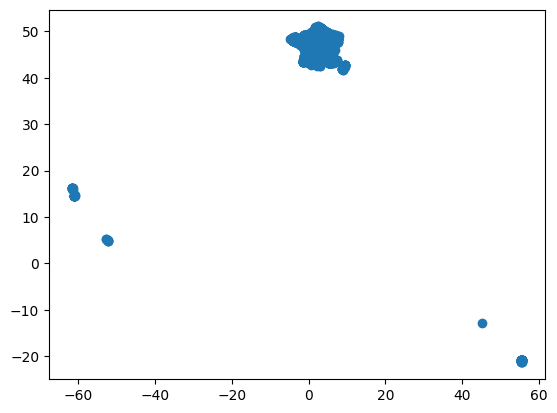

In [33]:
plt.scatter(x=coordonneeEtablissementGPS['XX'], y=coordonneeEtablissementGPS['YY'])
plt.show()

In [34]:
coordonneeEtablissementGPS=coordonneeEtablissementGPS[["siret","coordonneeEtablissementGPS"]]
structures=pd.merge(structures,coordonneeEtablissementGPS,how='left',on='siret')

In [35]:
structures["Adresse"]=structures[['complementAdresseEtablissement','numeroVoieEtablissement','typeVoieEtablissement','libelleVoieEtablissement','codePostalEtablissement','libelleCommuneEtablissement']].agg(lambda x:' '.join(x.dropna().astype(str)), axis=1)
structures["Adresse"]

0         BATIMENT I 80 ROUTE DES LUCIOLES 06560 VALBONNE
1            46 RUE DE LA TELEMATIQUE 42000 SAINT-ETIENNE
2                   2 PLACE EDMOND REGNAULT 26000 VALENCE
3               39 RUE DE LA CHAUSSEE D'ANTIN 75009 PARIS
4        14 AVENUE DU GENERAL DE GAULLE 94160 SAINT-MANDE
                              ...                        
6427                 006-014 6 RUE LA PEROUSE 75016 PARIS
6428    ZI PARIS NORD II 90 RUE DES VANESSES 93420 VIL...
6429            1 MAIL DES 20 000 LIEUES 44340 BOUGUENAIS
6430                50-51 50 ALLEES MARINES 64100 BAYONNE
6431               2 RUE D'ALSACE LORRAINE 31000 TOULOUSE
Name: Adresse, Length: 6432, dtype: object

In [36]:
structures

,siren,siret,statut,message,etablissementSiege,dateCreationEtablissement,dateDernierTraitementEtablissement,etatAdministratifUniteLegale,dateCreationUniteLegale,siretSiege,...,identifiantAdresseEtablissement,codeCommuneEtablissement,sigleUniteLegale,dernierNumeroVoieEtablissement,codePaysEtrangerEtablissement,libellePaysEtrangerEtablissement,libelleCommuneEtrangerEtablissement,epsg,coordonneeEtablissementGPS,Adresse
0,799066618,79906661800031,200,OK,True,2024-07-05,2024-11-22T14:05:38.787,A,2013-12-06,79906661800031,...,061520195_B,06152,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"43.6141899674233,7.04736900349428",BATIMENT I 80 ROUTE DES LUCIOLES 06560 VALBONNE
1,390220119,39022011900049,200,OK,True,2024-11-20,2024-12-02T17:16:27.771,A,1993-01-29,39022011900049,...,422188363_B,42218,S&CC,NaN,NaN,NaN,NaN,EPSG:2154,"45.45731003636182,4.396336025955309",46 RUE DE LA TELEMATIQUE 42000 SAINT-ETIENNE
2,538758236,53875823600052,200,OK,True,2024-06-18,2024-12-02T09:54:12.037,A,2011-12-12,53875823600052,...,263622842_B,26362,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"44.928855011344815,4.929441941065717",2 PLACE EDMOND REGNAULT 26000 VALENCE
3,497511923,49751192300052,200,OK,True,2024-04-01,2024-12-02T10:44:40.671,A,2007-04-03,49751192300052,...,751091949_B,75109,NaN,41,NaN,NaN,NaN,EPSG:2154,"48.87497696179399,2.33230402380858",39 RUE DE LA CHAUSSEE D'ANTIN 75009 PARIS
4,879223923,87922392300035,200,OK,True,2024-10-24,2024-11-29T12:01:02.192,A,2019-09-15,87922392300035,...,940674137_B,94067,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"48.84518701681063,2.4174589727800364",14 AVENUE DU GENERAL DE GAULLE 94160 SAINT-MANDE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6427,784617011,78461701100027,200,OK,True,1989-08-01,2024-03-30T11:35:14.175,A,1900-01-01,78461701100027,...,751165336_B,75116,CHEC,NaN,NaN,NaN,NaN,EPSG:2154,"48.869006,2.2928729999999997",006-014 6 RUE LA PEROUSE 75016 PARIS
6428,784756413,78475641300117,200,OK,True,1992-09-01,2024-03-30T12:24:38.895,A,1900-01-01,78475641300117,...,930781367_B,93078,IS,NaN,NaN,NaN,NaN,EPSG:2154,"48.971945,2.5053859999999992",ZI PARIS NORD II 90 RUE DES VANESSES 93420 VIL...
6429,750801771,75080177100023,200,OK,True,2022-07-01,2024-03-30T00:35:39.567,A,2012-03-07,75080177100023,...,440201993_B,44020,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"47.157306,-1.5915709999999998",1 MAIL DES 20 000 LIEUES 44340 BOUGUENAIS
6430,186400057,18640005700011,200,OK,True,1983-09-27,2024-03-30T18:41:10.472,A,1948-06-14,18640005700011,...,641020065_B,64102,CCI,NaN,NaN,NaN,NaN,EPSG:2154,"43.49888100000001,-1.4886939999999984",50-51 50 ALLEES MARINES 64100 BAYONNE


In [37]:
writer = pd.ExcelWriter(dir_output+"structures_"+datetime.now().strftime('%Y-%m-%d')+".xlsx", engine='xlsxwriter')
structures.to_excel(writer,sheet_name="data", index=False)
writer.close()

In [38]:
les__structures=pd.merge(sirets,structures,how='left',on=['siret'])
les__adresse=les__structures[["siret","Adresse","coordonneeEtablissementGPS"]].drop_duplicates('siret')
les__adresse=les__adresse.rename(columns={"siret": "dern_numero_siret"})
les__structures

,active,type,siret,resourceId,createdBy,createdAt,id,startDate,endDate,updatedBy,...,identifiantAdresseEtablissement,codeCommuneEtablissement,sigleUniteLegale,dernierNumeroVoieEtablissement,codePaysEtrangerEtablissement,libellePaysEtrangerEtablissement,libelleCommuneEtrangerEtablissement,epsg,coordonneeEtablissementGPS,Adresse
0,True,siret,79906661800031,9unA5,"{'firstName': 'Yann', 'lastName': 'Caradec', '...",2024-12-04T10:00:07.041Z,qaij7f8an2y9wbu,2024-11-01,None,NaN,...,061520195_B,06152,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"43.6141899674233,7.04736900349428",BATIMENT I 80 ROUTE DES LUCIOLES 06560 VALBONNE
1,True,siret,39022011900049,zh675,"{'firstName': 'Yann', 'lastName': 'Caradec', '...",2024-12-03T19:29:44.035Z,emc4pvrae5ybtvq,2024-11-20,None,NaN,...,422188363_B,42218,S&CC,NaN,NaN,NaN,NaN,EPSG:2154,"45.45731003636182,4.396336025955309",46 RUE DE LA TELEMATIQUE 42000 SAINT-ETIENNE
2,True,siret,53875823600052,br3Cc,"{'firstName': 'Yann', 'lastName': 'Caradec', '...",2024-12-03T19:01:49.249Z,bxu25ct7tt22rub,2024-06-18,None,NaN,...,263622842_B,26362,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"44.928855011344815,4.929441941065717",2 PLACE EDMOND REGNAULT 26000 VALENCE
3,True,siret,49751192300052,emqo9,"{'firstName': 'Yann', 'lastName': 'Caradec', '...",2024-12-03T18:57:54.145Z,8jwgknfyemkpucn,2024-04-01,None,NaN,...,751091949_B,75109,NaN,41,NaN,NaN,NaN,EPSG:2154,"48.87497696179399,2.33230402380858",39 RUE DE LA CHAUSSEE D'ANTIN 75009 PARIS
4,True,siret,87922392300035,xYJ6W,"{'firstName': 'Yann', 'lastName': 'Caradec', '...",2024-12-02T10:42:17.009Z,j0rwt7x7o7zzjzz,2024-10-24,None,NaN,...,940674137_B,94067,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"48.84518701681063,2.4174589727800364",14 AVENUE DU GENERAL DE GAULLE 94160 SAINT-MANDE
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6302,True,siret,19133340000015,1tI7C,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T18:51:27.578Z,1iS0Maw0viOj9am,None,None,NaN,...,132133746_B,13213,CENTRALE MARSEILLE,NaN,NaN,NaN,NaN,EPSG:2154,"43.341539000000004,5.436390000000001",TECHNOPOLE CHATEAU GOMBERT 38 RUE FREDERIC JOL...
6303,True,siret,19101060200032,8tVLr,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T18:51:26.539Z,RYLD0h34ZT4QFf7,None,None,NaN,...,10387adwl_B,10387,UTT,NaN,NaN,NaN,NaN,EPSG:2154,"48.272346000000006,4.07644",12 RUE MARIE CURIE 10000 TROYES
6304,False,siret,19060931300019,7CYWd,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T18:51:26.155Z,yJld3FADbXaLsw9,None,None,NaN,...,NaN,06088,NaN,NaN,NaN,NaN,NaN,EPSG:2154,NaN,GRAND CHATEAU 28 AV VALROSE 06000 NICE
6305,False,siret,59702084100016,18120,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T18:51:23.386Z,d2YbUlEQY0wIIxf,None,2021-11,NaN,...,412170100_B,41217,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"47.33232099999999,1.2000629999999999",23 ROUTE DE TOURS 41400 SAINT-JULIEN-DE-CHEDON


In [39]:
filename_in = dir_output+"les_structures_"+datetime.now().strftime('%Y-%m-%d')+".xlsx"
writer = pd.ExcelWriter(filename_in, engine='xlsxwriter')
les__structures.to_excel(writer,sheet_name="data", index=False)
writer.close()
ftp_server = ftplib.FTP(ftp_HOSTNAME, ftp_USERNAME, ftp_PASSWORD)
filename_out = "les_structures.xlsx"
with open(filename_in, "rb") as file:
    ftp_server.storbinary(f"STOR {filename_out}", file)
print(ftp_server.dir())
ftp_server.quit()

drwx---r-x    2 25811      users              17 Dec  5 17:52 .
drwx---r-x    2 25811      users              17 Dec  5 17:52 ..
-rw----r--    1 25811      users          603138 Mar  5  2024 CII.xlsx
-rw----r--    1 25811      users         3435698 Mar  5  2024 CIR.xlsx
-rw----r--    1 25811      users           41003 Mar  5  2024 ORGANISMES.xlsx
-rw----r--    1 25811      users         1678436 Mar  5  2024 _CII.xlsx
-rw----r--    1 25811      users         8777350 Mar  5  2024 _CIR.xlsx
-rw----r--    1 25811      users           79559 Mar  5  2024 _ORGANISMES.xlsx
-rw----r--    1 25811      users          244292 Nov 22 10:13 biblio.xlsx
-rw----r--    1 25811      users           21901 Dec  4 11:42 cc.xlsx
-rw----r--    1 25811      users           85615 Nov 21 10:26 evt_data.xlsx
-rw----r--    1 25811      users          400112 Jul 23 10:08 les_princ_etabs_infos.xlsx
-rw----r--    1 25811      users         2073302 Dec  5 17:52 les_structures.xlsx
-rw----r--    1 25811      users     

'221-Goodbye. You uploaded 2025 and downloaded 0 kbytes.\n221 Logout.'

In [40]:
siret_a_fermer=les__structures[((les__structures["active"]!=False)&(les__structures["etatAdministratifUniteLegale"]=="C"))]
siret_a_fermer=siret_a_fermer.sort_values('dateDernierTraitementEtablissement',ascending=False)
filename_in = dir_output+"siret_a_fermer_"+datetime.now().strftime('%Y-%m-%d')+".xlsx"
writer = pd.ExcelWriter(filename_in, engine='xlsxwriter')
siret_a_fermer.to_excel(writer,sheet_name="data", index=False)
writer.close()
ftp_server = ftplib.FTP(ftp_HOSTNAME, ftp_USERNAME, ftp_PASSWORD)
filename_out = "siret_a_fermer.xlsx"
with open(filename_in, "rb") as file:
    ftp_server.storbinary(f"STOR {filename_out}", file)
print(ftp_server.dir())
ftp_server.quit()
siret_a_fermer

drwx---r-x    2 25811      users              17 Dec  5 17:52 .
drwx---r-x    2 25811      users              17 Dec  5 17:52 ..
-rw----r--    1 25811      users          603138 Mar  5  2024 CII.xlsx
-rw----r--    1 25811      users         3435698 Mar  5  2024 CIR.xlsx
-rw----r--    1 25811      users           41003 Mar  5  2024 ORGANISMES.xlsx
-rw----r--    1 25811      users         1678436 Mar  5  2024 _CII.xlsx
-rw----r--    1 25811      users         8777350 Mar  5  2024 _CIR.xlsx
-rw----r--    1 25811      users           79559 Mar  5  2024 _ORGANISMES.xlsx
-rw----r--    1 25811      users          244292 Nov 22 10:13 biblio.xlsx
-rw----r--    1 25811      users           21901 Dec  4 11:42 cc.xlsx
-rw----r--    1 25811      users           85615 Nov 21 10:26 evt_data.xlsx
-rw----r--    1 25811      users          400112 Jul 23 10:08 les_princ_etabs_infos.xlsx
-rw----r--    1 25811      users         2073302 Dec  5 17:52 les_structures.xlsx
-rw----r--    1 25811      users     

,active,type,siret,resourceId,createdBy,createdAt,id,startDate,endDate,updatedBy,...,identifiantAdresseEtablissement,codeCommuneEtablissement,sigleUniteLegale,dernierNumeroVoieEtablissement,codePaysEtrangerEtablissement,libellePaysEtrangerEtablissement,libelleCommuneEtrangerEtablissement,epsg,coordonneeEtablissementGPS,Adresse
3495,True,siret,89005681500016,sXpbq,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T19:37:59.737Z,jYwq4W4S9sYXApD,2020-10,None,NaN,...,751110272_B,75111,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"48.864115,2.3669249999999997",122 RUE AMELOT 75011 PARIS
873,NaN,siret,80389689300028,9wc3i,"{'firstName': 'Mialy', 'lastName': 'Rakotondra...",2024-07-16T10:58:35.700Z,9gmg0ygqa5f7sxs,None,None,NaN,...,132104237_B,13210,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"43.27485299999999,5.430648",102 BOULEVARD DES GRANDS PINS 13010 MARSEILLE
1971,NaN,siret,52162634100031,sr87d,"{'firstName': 'Alexandra', 'lastName': 'Bounya...",2024-01-15T15:26:34.100Z,wnvq4rx6j8yp835,None,None,NaN,...,831291095_B,83129,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"43.099339000000015,5.852053",ENTREE A 945 AVENUE MARECHAL JUIN 83140 SIX-FO...
2146,NaN,siret,87871911100014,1valx,"{'firstName': 'Alexandra', 'lastName': 'Bounya...",2024-01-15T15:10:55.198Z,m7swv6upwsj7pke,None,None,NaN,...,693830030_B,69383,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"45.754003999999995,4.856114",59 RUE DE L'ABONDANCE 69003 LYON
2188,NaN,siret,88110142200015,zhgua,"{'firstName': 'Alexandra', 'lastName': 'Bounya...",2024-01-15T15:04:45.122Z,b2h17q57dzwje4w,None,None,NaN,...,315557268_B,31555,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"43.56918300000001,1.4661060000000004",INSA 135 AVENUE DE RANGUEIL 31400 TOULOUSE
5188,True,siret,45327847500067,Ze5YB,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T19:08:47.314Z,ejMum4VisUG68tv,2004-04-27,None,NaN,...,381854526_B,38185,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"45.191772,5.712371999999999",6EME ETAGE 3 AVENUE DOYEN LOUIS WEIL 38000 GRE...
2109,NaN,siret,90482027100016,tp7rz,"{'firstName': 'Alexandra', 'lastName': 'Bounya...",2024-01-15T15:12:22.283Z,rl9wdmlxdqkkfnu,None,None,NaN,...,693825720_B,69382,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"45.76221900000001,4.834230000000001",57 RUE PRESIDENT EDOUARD HERRIOT 69002 LYON
3242,True,siret,79186482000034,5IjmS,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T19:38:34.707Z,bpo9y6uy3nO69E4,2013-02,None,NaN,...,371240140_B,37124,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"47.35832,0.7747800000000011",4 ALLEE DE CHINON 37270 LARCAY
1906,NaN,siret,91431592400011,ktqgv,"{'firstName': 'Mialy', 'lastName': 'Rakotondra...",2024-01-29T09:36:00.882Z,7oztdp5iq2nrhi2,None,None,NaN,...,914774850_B,91477,NaN,NaN,NaN,NaN,NaN,EPSG:2154,"48.713066000000005,2.20971",STOP&WORK-LE PLAYGROUND PARIS-SACLAY 3 BOULEVA...
2954,NaN,siret,43919697300036,9RchS,"{'firstName': 'Mihoub', 'lastName': 'Debache',...",2023-03-21T15:24:02.382Z,5nrhATuHcRbgj51,None,None,NaN,...,NaN,91228,NaN,NaN,NaN,NaN,NaN,EPSG:2154,NaN,CAMPUS3 PEPINIERE GENOPOLE ENTREPRISES 4 RUE P...


In [41]:
response = requests.get(
    'https://mesr.opendatasoft.com/api/automation/v1.0/datasets/?limit=999', 
    headers={"Authorization": "apikey "+apikeyods})
result=response.json()
df = pd.DataFrame(result["results"])
od = df[df['dataset_id'].str.contains('siret')]
od

,uid,dataset_id,is_published,is_restricted,default_security,created_at,updated_at,metadata,asset_type
460,da_pcgcmx,fr-esr-siret-a-fermer-dans-paysage-v2,True,True,"{'is_data_visible': True, 'visible_fields': No...",2024-01-23T15:51:25Z,2024-10-10T19:38:43Z,{'visualization': {'analyze_disabled': {'value...,ods_dataset


In [42]:
dataset_uid="da_pcgcmx"

In [43]:
try:
    responseF = requests.post('https://mesr.opendatasoft.com/api/automation/v1.0/datasets/'+dataset_uid+'/publish/', headers={"Authorization": "apikey "+apikeyods})
    responseF.raise_for_status()
except requests.exceptions.HTTPError as errh:
    print(dataset_uid+" > KO : publish ", responseF.status_code)
print("fin")

fin


In [44]:
headers = {
    'Accept': 'application/json',
    'X-API-KEY': apikey,
}
try:
    response = requests.get("https://api.paysage.dataesr.ovh/legal-categories?limit=2000", headers=headers)
    response.raise_for_status()
    result = response.json()
    legcat = pd.DataFrame(result["data"])
    time.sleep(.6)
except requests.exceptions.HTTPError as errh:
    print("legcat > KO : ", response.status_code)
legcat

,longNameFr,createdBy,createdAt,id,inseeCode,shortNameFr,acronymFr,pluralNameFr,descriptionFr,longNameEn,...,otherNames,sector,legalPersonality,inPublicResearch,wikidataId,websiteFr,websiteEn,comment,updatedBy,updatedAt
0,Assujetti unique à la TVA,"{'firstName': 'Yann', 'lastName': 'Caradec', '...",2024-01-26T20:45:40.937Z,tyuoti8rn45agv5,2800,None,None,Assujettis uniques à la TVA,None,None,...,[Groupe TVA],privé,personne morale de droit privé,None,None,None,None,None,NaN,NaN
1,Établissement public de coopération scientifique,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T17:33:13.836Z,I0jvVI0jvVI0jvV,None,None,EPCS,Établissements publics de coopération scientif...,None,None,...,[EPCS],public,personne morale de droit public,None,None,None,None,None,"{'firstName': 'Alexandra', 'lastName': 'Bounya...",2023-09-11T12:00:28.737Z
2,Non connu,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T17:33:13.830Z,vXSCVvXSCVvXSCV,None,None,None,None,None,None,...,[],sans objet,None,None,None,None,None,None,NaN,NaN
3,SARL d'aménagement foncier et d'équipement rural,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T17:33:13.830Z,7F2cu7F2cu7F2cu,5430,None,None,None,None,None,...,[SARL SAFER],privé,personne morale de droit privé,None,None,None,None,None,NaN,NaN
4,SARL immobilière de gestion,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T17:33:13.816Z,Nc9hFNc9hFNc9hF,5426,None,None,None,None,None,...,[SARL],privé,personne morale de droit privé,None,None,None,None,None,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
260,Groupement forestier,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T17:33:06.547Z,294d6294d6294d6,6536,None,None,None,None,None,...,[],privé,personne morale de droit privé,None,None,None,None,None,NaN,NaN
261,Société européenne,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T17:33:06.504Z,4P0P84P0P84P0P8,5800,None,None,None,None,None,...,[],privé,personne morale de droit privé,None,None,None,None,None,NaN,NaN
262,Exploitant public,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T17:33:06.496Z,VE5JsVE5JsVE5Js,4130,None,None,None,None,None,...,[],privé,personne morale de droit privé,None,None,None,None,None,NaN,NaN
263,Société civile d'exploitation agricole,"{'firstName': 'Migration', 'lastName': 'V1', '...",2022-11-29T17:33:06.487Z,95Z2A95Z2A95Z2A,6597,None,None,None,None,None,...,[],privé,personne morale de droit privé,None,None,None,None,None,NaN,NaN


In [45]:
legcat=legcat[["id","longNameFr","inseeCode","acronymFr","sector","legalPersonality"]]

In [46]:
def extract_legcat(id,inseeCode):
    try:
        response = requests.get("https://api.paysage.dataesr.ovh/relations?filters[relationTag]=structure-categorie-juridique&filters[relatedObjectId]="+id+"&limit=2000&sort=-startDate", headers=headers)
        response.raise_for_status()
        result = response.json()
        time.sleep(.75)
    except requests.exceptions.HTTPError as errh:
        print("legcat > KO : ", response.status_code)
    if result["totalCount"]>0 :
        legcat = pd.json_normalize(result["data"], 
                     meta=['relatedObjectId','active','startDate','endDate','resourceId','updatedAt', ['resource', 'creationDate'], ['resource', 'closureDate'], ['resource', 'currentLocalisation', 'cityId'], ['resource', 'currentLocalisation', 'iso3']])
        legcat=legcat.drop(columns='id')
        legcat=legcat.rename(columns={"relatedObjectId": "id"})
        legcat["inseeCode"]=inseeCode
        return(legcat)

In [47]:
structures_legcat=pd.DataFrame(columns = ["id"])
i=0
for ind in legcat.index:
    id = legcat["id"][ind]
    inseeCode = legcat["inseeCode"][ind]
    i=i+1
    if i%50==0:
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S')+" "+str(i)+"/{:0.1f} %".format(i*100/len(legcat.index)))
    structure_legcat = extract_legcat(id,inseeCode)
    structures_legcat = pd.concat([structures_legcat, structure_legcat], axis=0, join='outer')
print("Terminé")

2024-12-05 17:53:44 50/18.9 %
2024-12-05 17:54:36 100/37.7 %
2024-12-05 17:55:31 150/56.6 %
2024-12-05 17:56:24 200/75.5 %
2024-12-05 17:58:46 250/94.3 %
Terminé


In [48]:
structures_legcat

,id,resourceId,createdAt,otherAssociatedObjects,relationsGroupId,relationTag,startDate,endDate,endDatePrevisional,mandatePosition,...,resource.currentName.comment,endDateOfficialText.nature,endDateOfficialText.type,endDateOfficialText.pageUrl,endDateOfficialText.title,endDateOfficialText.id,endDateOfficialText.displayName,endDateOfficialText.collection,endDateOfficialText.href,endDateOfficialText.publicationDate
0,I0jvVI0jvVI0jvV,86UpY,2022-11-29T22:14:52.032Z,[],None,structure-categorie-juridique,2012-10-04,2013-07-23,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,I0jvVI0jvVI0jvV,Olkw0,2022-11-29T22:14:51.085Z,[],None,structure-categorie-juridique,2012-08-06,2013-07-23,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,I0jvVI0jvVI0jvV,HE9sT,2022-11-29T22:14:42.451Z,[],None,structure-categorie-juridique,2012-04-27,2013-07-23,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,I0jvVI0jvVI0jvV,Mz9Uy,2022-11-29T22:14:51.551Z,[],None,structure-categorie-juridique,2012-04-27,2013-07-23,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,I0jvVI0jvVI0jvV,bI34a,2022-11-29T22:14:42.452Z,[],None,structure-categorie-juridique,2012-03-01,2012-02-29,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3,4P0P84P0P84P0P8,IxdAw,2022-11-29T22:14:04.012Z,[],None,structure-categorie-juridique,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4P0P84P0P84P0P8,Dt13r,2023-01-20T09:34:48.853Z,[],None,structure-categorie-juridique,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,4P0P84P0P84P0P8,IJuw2,2023-03-21T15:25:03.736Z,[],None,structure-categorie-juridique,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,4P0P84P0P84P0P8,3rdwr,2023-12-07T18:50:38.633Z,[],None,structure-categorie-juridique,None,None,None,None,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
structures_legcat=structures_legcat[["id","resourceId","startDate","endDate","endDatePrevisional","active","resource.displayName","resource.creationDate","resource.closureDate","resource.structureStatus","resource.currentLocalisation.cityId","resource.currentLocalisation.iso3"]]
catjur = pd.merge(legcat,structures_legcat,how='inner',on=['id'])
filename_in = dir_output+"structures_legcat_"+datetime.now().strftime('%Y-%m-%d')+".xlsx"
writer = pd.ExcelWriter(filename_in, engine='xlsxwriter')
catjur.to_excel(writer,sheet_name="data", index=False)
writer.close()

In [50]:
sirets2=sirets[['resourceId','siret','startDate','endDate','active']]
sirets2=sirets2.rename(columns={'startDate':'startDate_siret','endDate':'endDate_siret','active':'active_siret'})
sirets2

,resourceId,siret,startDate_siret,endDate_siret,active_siret
0,9unA5,79906661800031,2024-11-01,None,True
1,zh675,39022011900049,2024-11-20,None,True
2,br3Cc,53875823600052,2024-06-18,None,True
3,emqo9,49751192300052,2024-04-01,None,True
4,xYJ6W,87922392300035,2024-10-24,None,True
...,...,...,...,...,...
6302,1tI7C,19133340000015,None,None,True
6303,8tVLr,19101060200032,None,None,True
6304,7CYWd,19060931300019,None,None,False
6305,18120,59702084100016,None,2021-11,False


In [51]:
catjur2 = pd.merge(catjur,sirets2,how='inner',on=['resourceId'])
catjur2

,id,longNameFr,inseeCode,acronymFr,sector,legalPersonality,resourceId,startDate,endDate,endDatePrevisional,...,resource.displayName,resource.creationDate,resource.closureDate,resource.structureStatus,resource.currentLocalisation.cityId,resource.currentLocalisation.iso3,siret,startDate_siret,endDate_siret,active_siret
0,I0jvVI0jvVI0jvV,Établissement public de coopération scientifique,None,EPCS,public,personne morale de droit public,86UpY,2012-10-04,2013-07-23,None,...,Université Paris Lumières,2012-10-04,2024-07-31,inactive,75113,FRA,13002147000021,None,2024-07-31,False
1,6NFk86NFk86NFk8,"Établissement public à caractère scientifique,...",7383,EPSCP,public,personne morale de droit public,86UpY,2013-07-24,2024-07-31,None,...,Université Paris Lumières,2012-10-04,2024-07-31,inactive,75113,FRA,13002147000021,None,2024-07-31,False
2,I0jvVI0jvVI0jvV,Établissement public de coopération scientifique,None,EPCS,public,personne morale de droit public,Olkw0,2012-08-06,2013-07-23,None,...,Université de recherche Paris-Sciences-et-Lettres,2012-08-06,2019-12-31,inactive,75106,FRA,13001744500011,None,2019-12-31,False
3,6NFk86NFk86NFk8,"Établissement public à caractère scientifique,...",7383,EPSCP,public,personne morale de droit public,Olkw0,2013-07-24,2019-12-31,None,...,Université de recherche Paris-Sciences-et-Lettres,2012-08-06,2019-12-31,inactive,75106,FRA,13001744500011,None,2019-12-31,False
4,I0jvVI0jvVI0jvV,Établissement public de coopération scientifique,None,EPCS,public,personne morale de droit public,Mz9Uy,2012-04-27,2013-07-23,None,...,Institut polytechnique Grand Paris,2012-04-27,2018-02-28,inactive,95127,FRA,13001795700023,2012-04-27,2014-12-31,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5376,4P0P84P0P84P0P8,Société européenne,5800,None,privé,personne morale de droit privé,Dt13r,None,None,None,...,Getlink,None,None,active,75108,FRA,48338514200060,2022-12-20,None,True
5377,4P0P84P0P84P0P8,Société européenne,5800,None,privé,personne morale de droit privé,Dt13r,None,None,None,...,Getlink,None,None,active,75108,FRA,48338514200052,None,2022-12-20,False
5378,4P0P84P0P84P0P8,Société européenne,5800,None,privé,personne morale de droit privé,IJuw2,None,None,None,...,Valneva,2005-08-16,None,active,44162,FRA,42249756000041,None,None,NaN
5379,4P0P84P0P84P0P8,Société européenne,5800,None,privé,personne morale de droit privé,3rdwr,None,None,None,...,Trod medical,2006-07-01,2022-12-31,inactive,None,FRA,49079169600050,None,2022-12-31,False


In [52]:
les__structures2=les__structures[['siret','etablissementSiege','dateCreationEtablissement','etatAdministratifUniteLegale','dateCreationUniteLegale','sigleUniteLegale','denominationUniteLegale','categorieJuridiqueUniteLegale','codeCommuneEtablissement']]
les__structures2=les__structures2.drop_duplicates()
catjur3 = pd.merge(catjur2,les__structures2,how='inner',on=['siret'])
catjur3

,id,longNameFr,inseeCode,acronymFr,sector,legalPersonality,resourceId,startDate,endDate,endDatePrevisional,...,endDate_siret,active_siret,etablissementSiege,dateCreationEtablissement,etatAdministratifUniteLegale,dateCreationUniteLegale,sigleUniteLegale,denominationUniteLegale,categorieJuridiqueUniteLegale,codeCommuneEtablissement
0,I0jvVI0jvVI0jvV,Établissement public de coopération scientifique,None,EPCS,public,personne morale de droit public,86UpY,2012-10-04,2013-07-23,None,...,2024-07-31,False,True,2016-11-01,C,2015-01-01,COMUE,COMMUNAUTE D UNIVERSITES ET ETABLISSEMENTS UNI...,7383,75113
1,6NFk86NFk86NFk8,"Établissement public à caractère scientifique,...",7383,EPSCP,public,personne morale de droit public,86UpY,2013-07-24,2024-07-31,None,...,2024-07-31,False,True,2016-11-01,C,2015-01-01,COMUE,COMMUNAUTE D UNIVERSITES ET ETABLISSEMENTS UNI...,7383,75113
2,I0jvVI0jvVI0jvV,Établissement public de coopération scientifique,None,EPCS,public,personne morale de droit public,Olkw0,2012-08-06,2013-07-23,None,...,2019-12-31,False,True,2012-08-01,C,2012-08-01,COMUE,COMMUNAUTE D'UNIVERSITES ET ETABLISSEMENTS UNI...,7383,75105
3,6NFk86NFk86NFk8,"Établissement public à caractère scientifique,...",7383,EPSCP,public,personne morale de droit public,Olkw0,2013-07-24,2019-12-31,None,...,2019-12-31,False,True,2012-08-01,C,2012-08-01,COMUE,COMMUNAUTE D'UNIVERSITES ET ETABLISSEMENTS UNI...,7383,75105
4,I0jvVI0jvVI0jvV,Établissement public de coopération scientifique,None,EPCS,public,personne morale de droit public,Mz9Uy,2012-04-27,2013-07-23,None,...,2014-12-31,False,True,2015-01-01,C,2012-04-24,COMUE,COMMUNAUTE D UNIVERSITES ET ETABLISSEMENTS INS...,7383,95127
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5376,4P0P84P0P84P0P8,Société européenne,5800,None,privé,personne morale de droit privé,Dt13r,None,None,None,...,None,True,True,2022-12-20,A,2005-07-12,NaN,GETLINK S.E.,5800,75108
5377,4P0P84P0P84P0P8,Société européenne,5800,None,privé,personne morale de droit privé,Dt13r,None,None,None,...,2022-12-20,False,False,2011-02-08,A,2005-07-12,NaN,GETLINK S.E.,5800,75108
5378,4P0P84P0P84P0P8,Société européenne,5800,None,privé,personne morale de droit privé,IJuw2,None,None,None,...,None,NaN,True,2005-08-16,A,1999-03-24,NaN,VALNEVA,5800,44162
5379,4P0P84P0P84P0P8,Société européenne,5800,None,privé,personne morale de droit privé,3rdwr,None,None,None,...,2022-12-31,False,True,2013-07-17,C,2006-07-01,NaN,TROD MEDICAL,5800,NaN


In [53]:
filename_in = dir_output+"catjur3_"+datetime.now().strftime('%Y-%m-%d')+".xlsx"
writer = pd.ExcelWriter(filename_in, engine='xlsxwriter')
catjur3.to_excel(writer,sheet_name="data", index=False)
writer.close()

In [54]:
headers = {
    'X-INSEE-Api-Key-Integration': inseekey,
}
def extract_siren2(numero_siren):
    global dernier_traitement_siren
    structure = {}
    sep=";"
    params = {
        'q': 'siren:'+numero_siren,
        'masquerValeursNulles' : 'true'
    }
    if os.path.isfile(dir_api+"/"+numero_siren+".json"):
        f = open(dir_api+"/"+numero_siren+".json")
        result = json.load(f)
        f.close()
    else:
        response = requests.get('https://api.insee.fr/api-sirene/3.11/siren', params=params, headers=headers)
        writeFile =open(dir_api+"/"+numero_siren+".json", 'w')
        json.dump(response.json(),writeFile)
        writeFile.close()
        result = response.json()
        time.sleep(2.02)
    if result["header"]["statut"]==200:
        if "unitesLegales" in result:
            if result["unitesLegales"][0]["nombrePeriodesUniteLegale"]>0:
                structure = pd.DataFrame(result["unitesLegales"][0]["periodesUniteLegale"])
                structure["changements"]=""
                structure["les_changements"]=""
            if "dateCreationUniteLegale" in result["unitesLegales"][0]:
                structure["dateCreationUniteLegale"]=result["unitesLegales"][0]["dateCreationUniteLegale"]
            if "identifiantAssociationUniteLegale" in result["unitesLegales"][0]:
                structure["identifiantAssociationUniteLegale"]=result["unitesLegales"][0]["identifiantAssociationUniteLegale"]
            if "sigleUniteLegale" in result["unitesLegales"][0]:
                structure["sigleUniteLegale"]=result["unitesLegales"][0]["sigleUniteLegale"]
            if "dateDernierTraitementUniteLegale" in result["unitesLegales"][0]:
                structure["dateDernierTraitementUniteLegale"]=result["unitesLegales"][0]["dateDernierTraitementUniteLegale"]
            if "categorieEntreprise" in result["unitesLegales"][0]:
                structure["categorieEntreprise"]=result["unitesLegales"][0]["categorieEntreprise"]
            if 'changementNicSiegeUniteLegale' in structure.columns:
                structure.loc[structure["changementNicSiegeUniteLegale"], 'changements'] +="Nic Siege;"
                if 'nicSiegeUniteLegale' in structure.columns:
                    structure.loc[structure["changementNicSiegeUniteLegale"], 'les_changements'] +=numero_siren+structure["nicSiegeUniteLegale"]+";"
                    structure["dern_numero_siret"]=numero_siren+structure[structure["changementNicSiegeUniteLegale"]]["nicSiegeUniteLegale"].head(1)
            if 'changementEtatAdministratifUniteLegale' in structure.columns:
                structure.loc[structure["changementEtatAdministratifUniteLegale"], 'changements'] +="État administratif;"
                if 'etatAdministratifUniteLegale' in structure.columns:
                    structure.loc[structure["changementEtatAdministratifUniteLegale"], 'les_changements'] +=structure["etatAdministratifUniteLegale"]+";"
            if 'changementCategorieJuridiqueUniteLegale' in structure.columns:
                structure.loc[structure["changementCategorieJuridiqueUniteLegale"], 'changements'] +="Catégorie juridique;"
                if 'categorieJuridiqueUniteLegale' in structure.columns:
                    structure.loc[structure["changementCategorieJuridiqueUniteLegale"], 'les_changements'] +=structure["categorieJuridiqueUniteLegale"]+";"
            if 'changementActivitePrincipaleUniteLegale' in structure.columns:
                structure.loc[structure["changementActivitePrincipaleUniteLegale"], 'changements'] +="Activité principale;"
                if 'activitePrincipaleUniteLegale' in structure.columns:
                    structure.loc[structure["changementActivitePrincipaleUniteLegale"], 'les_changements'] +=structure["activitePrincipaleUniteLegale"]+";"
            if 'changementDenominationUniteLegale' in structure.columns:
                structure.loc[structure["changementDenominationUniteLegale"], 'changements'] +="Dénomination;"
                if 'denominationUniteLegale' in structure.columns:
                    structure.loc[structure["changementDenominationUniteLegale"], 'les_changements'] +=structure["denominationUniteLegale"]+";"
            if 'changementDenominationUsuelleUniteLegale' in structure.columns:
                structure.loc[structure["changementDenominationUsuelleUniteLegale"], 'changements'] +="Dénomination usuelle;"
            if 'changementNomUniteLegale' in structure.columns:
                structure.loc[structure["changementNomUniteLegale"], 'changements'] +="Nom;"
            if 'changementNomUsageUniteLegale' in structure.columns:
                structure.loc[structure["changementNomUsageUniteLegale"], 'changements'] +="Nom d'usage;"
            if 'changementSocieteMissionUniteLegale' in structure.columns:
                structure.loc[structure["changementSocieteMissionUniteLegale"], 'changements'] +="Société à mission;"
            if 'changementEconomieSocialeSolidaireUniteLegale' in structure.columns:
                structure.loc[structure["changementEconomieSocialeSolidaireUniteLegale"], 'changements'] +="Champ de l'économie sociale et solidaire;"
            if 'changementCaractereEmployeurUniteLegale' in structure.columns:
                structure.loc[structure["changementCaractereEmployeurUniteLegale"], 'changements'] +="Caractère employeur;"
            structure["changements"] = structure["changements"].str[:-1]
            structure["les_changements"] = structure["les_changements"].str[:-1]
            structure['index_column'] = structure.index+1
            structure['index_column'] = result["unitesLegales"][0]["nombrePeriodesUniteLegale"]+1-structure['index_column']
        structure["numero_siren"] = numero_siren
        structure["statut"] = result["header"]["statut"]
        if numero_siren in siren_paysage_unique['siren'].values:
            id_paysage = siren_paysage_unique.loc[(siren_paysage['siren']==numero_siren), 'resourceId'].max()
            structure["paysage"] = "https://paysage.enseignementsup-recherche.gouv.fr/structures/"+id_paysage+"/presentation"
            structure["id_paysage"] = id_paysage
        else:
            structure["paysage"] = "https://paysage.enseignementsup-recherche.gouv.fr/rechercher?query="+numero_siren
        structure["annuaire"] = "https://annuaire-entreprises.data.gouv.fr/entreprise/"+numero_siren
        structure["ods"] = "https://data.enseignementsup-recherche.gouv.fr/explore/dataset/fr-esr-maj_structures_sirene/table/?sort=datedebut&refine.numero_siren="+numero_siren
        structure["dernier_traitement"]=dernier_traitement_siren
        return structure

In [55]:
dernier_traitement_siren=datetime.now().strftime('%Y-%m-%d %H:%M:%S')
maj_structure4 = extract_siren2("438178725")
maj_structure4

,dateDebut,etatAdministratifUniteLegale,changementEtatAdministratifUniteLegale,changementNomUniteLegale,changementNomUsageUniteLegale,denominationUniteLegale,changementDenominationUniteLegale,changementDenominationUsuelleUniteLegale,categorieJuridiqueUniteLegale,changementCategorieJuridiqueUniteLegale,...,dateDernierTraitementUniteLegale,dern_numero_siret,index_column,numero_siren,statut,paysage,id_paysage,annuaire,ods,dernier_traitement
0,2207-12-21,A,False,False,False,NEOSENS,False,False,5599,False,...,2024-03-22T14:26:06.001,43817872500034,6,438178725,200,https://paysage.enseignementsup-recherche.gouv...,ou6ib,https://annuaire-entreprises.data.gouv.fr/entr...,https://data.enseignementsup-recherche.gouv.fr...,2024-12-05 18:00:14
1,2008-01-01,A,False,False,False,NEOSENS,False,False,5599,False,...,2024-03-22T14:26:06.001,NaN,5,438178725,200,https://paysage.enseignementsup-recherche.gouv...,ou6ib,https://annuaire-entreprises.data.gouv.fr/entr...,https://data.enseignementsup-recherche.gouv.fr...,2024-12-05 18:00:14
2,2007-10-01,A,False,False,False,NEOSENS,False,False,5599,False,...,2024-03-22T14:26:06.001,NaN,4,438178725,200,https://paysage.enseignementsup-recherche.gouv...,ou6ib,https://annuaire-entreprises.data.gouv.fr/entr...,https://data.enseignementsup-recherche.gouv.fr...,2024-12-05 18:00:14
3,2003-12-25,A,False,False,False,NEOSENS,False,False,5599,False,...,2024-03-22T14:26:06.001,NaN,3,438178725,200,https://paysage.enseignementsup-recherche.gouv...,ou6ib,https://annuaire-entreprises.data.gouv.fr/entr...,https://data.enseignementsup-recherche.gouv.fr...,2024-12-05 18:00:14
4,2001-12-25,A,False,False,False,NEOSENS,False,False,5599,False,...,2024-03-22T14:26:06.001,NaN,2,438178725,200,https://paysage.enseignementsup-recherche.gouv...,ou6ib,https://annuaire-entreprises.data.gouv.fr/entr...,https://data.enseignementsup-recherche.gouv.fr...,2024-12-05 18:00:14
5,2001-06-29,A,False,False,False,NEOSENS,False,False,5599,False,...,2024-03-22T14:26:06.001,NaN,1,438178725,200,https://paysage.enseignementsup-recherche.gouv...,ou6ib,https://annuaire-entreprises.data.gouv.fr/entr...,https://data.enseignementsup-recherche.gouv.fr...,2024-12-05 18:00:14


In [56]:
maj_structures=pd.DataFrame(columns = ["numero_siren","statut"])
i=0
dernier_traitement_siren=datetime.now().strftime('%Y-%m-%d %H:%M:%S')
for ind in les_sirens.index:
    numero_siren = les_sirens[ind]
    i=i+1
    if i%500==0:
        print(datetime.now().strftime('%Y-%m-%d %H:%M:%S')+" "+str(i)+"/{:0.1f} %".format(i*100/len(les_sirens.index)))
    maj_structure = extract_siren2(numero_siren)
    maj_structure = pd.DataFrame(maj_structure)
    if (maj_structures.empty) & (not maj_structure.empty):
        maj_structures=maj_structure
    if not maj_structure.empty:
        maj_structures = pd.concat([maj_structures, maj_structure], axis=0, join='outer')
print("Terminé")

2024-12-05 18:00:27 500/9.6 %
2024-12-05 18:00:37 1000/19.2 %
2024-12-05 18:00:49 1500/28.8 %
2024-12-05 18:01:01 2000/38.4 %
2024-12-05 18:01:13 2500/48.1 %
2024-12-05 18:01:25 3000/57.7 %
2024-12-05 18:01:38 3500/67.3 %
2024-12-05 18:01:51 4000/76.9 %
2024-12-05 18:02:05 4500/86.5 %
2024-12-05 18:02:18 5000/96.1 %
Terminé


In [57]:
selection = maj_structures[(maj_structures["dateDebut"]=="2207-12-21")].index
maj_structures[(maj_structures["dateDebut"]=="2207-12-21")]

,dateDebut,etatAdministratifUniteLegale,changementEtatAdministratifUniteLegale,changementNomUniteLegale,changementNomUsageUniteLegale,denominationUniteLegale,changementDenominationUniteLegale,changementDenominationUsuelleUniteLegale,categorieJuridiqueUniteLegale,changementCategorieJuridiqueUniteLegale,...,id_paysage,annuaire,ods,dernier_traitement,sigleUniteLegale,identifiantAssociationUniteLegale,denominationUsuelle1UniteLegale,denominationUsuelle2UniteLegale,nomUniteLegale,nomUsageUniteLegale
0,2207-12-21,A,False,False,False,NEOSENS,False,False,5599,False,...,ou6ib,https://annuaire-entreprises.data.gouv.fr/entr...,https://data.enseignementsup-recherche.gouv.fr...,2024-12-05 18:00:14,NaN,NaN,NaN,NaN,NaN,NaN


In [58]:
#selection = maj_structures[(maj_structures["dateDebut"]=="2207-12-21")].index
#maj_structures.loc[selection, 'dateDebut']="2012-07-26"
maj_structures=pd.merge(maj_structures,les__adresse,how='left',on=['dern_numero_siret'])
maj_structures=pd.merge(maj_structures,dateDernierTraitementEtablissement,how='left',on=['numero_siren'])
maj_structures=pd.merge(maj_structures,categoriesJuridiques,how='left',on=['categorieJuridiqueUniteLegale'])
maj_structures=pd.merge(maj_structures,activitePrincipaleUniteLegale,how='left',on=['nomenclatureActivitePrincipaleUniteLegale','activitePrincipaleUniteLegale'])
maj_structures=pd.merge(maj_structures,siret_paysage,how='left',on=['dern_numero_siret'])
maj_structures=pd.merge(maj_structures,maj_structures_sirene_prec,how='left',on=['numero_siren','index_column'])
selection = maj_structures[maj_structures["Nouveau"]!="Non"].index
maj_structures.loc[selection, 'Nouveau']="Oui"
maj_structures.loc[selection, 'Ajout']=datetime.now().strftime('%Y-%m-%d')
maj_structures.loc[(maj_structures["Siret_dans_paysage"].isnull()&~maj_structures["dern_numero_siret"].isnull()), 'Siret_dans_paysage']= "Non"
maj_structures

,dateDebut,etatAdministratifUniteLegale,changementEtatAdministratifUniteLegale,changementNomUniteLegale,changementNomUsageUniteLegale,denominationUniteLegale,changementDenominationUniteLegale,changementDenominationUsuelleUniteLegale,categorieJuridiqueUniteLegale,changementCategorieJuridiqueUniteLegale,...,nomUniteLegale,nomUsageUniteLegale,Adresse,coordonneeEtablissementGPS,dateDernierTraitementEtablissement,categorieJuridiqueUniteLegaleLib,activitePrincipaleUniteLegale_lib,Siret_dans_paysage,Ajout,Nouveau
0,2024-11-01,A,False,False,False,E-PHY-SCIENCE,False,False,5499,False,...,NaN,NaN,BATIMENT I 80 ROUTE DES LUCIOLES 06560 VALBONNE,"43.6141899674233,7.04736900349428",2024-11-22T14:05:38.787,Société à responsabilité limitée (sans autre i...,Recherche-développement en biotechnologie,Oui,2024-11-25,Non
1,2024-01-09,A,False,False,False,E-PHY-SCIENCE,False,False,5499,True,...,NaN,NaN,NaN,NaN,2024-11-22T14:05:38.787,Société à responsabilité limitée (sans autre i...,Recherche-développement en biotechnologie,NaN,2024-10-15,Non
2,2019-04-01,A,False,False,False,E-PHY-SCIENCE,False,False,5710,False,...,NaN,NaN,NaN,NaN,2024-11-22T14:05:38.787,"SAS, société par actions simplifiée",Recherche-développement en biotechnologie,NaN,2024-10-15,Non
3,2013-12-06,A,False,False,False,E-PHY-SCIENCE,False,False,5710,False,...,NaN,NaN,NaN,NaN,2024-11-22T14:05:38.787,"SAS, société par actions simplifiée",Recherche-développement en biotechnologie,NaN,2024-10-15,Non
4,2024-11-01,A,False,False,False,E-PHY-SCIENCE,False,False,5499,False,...,NaN,NaN,BATIMENT I 80 ROUTE DES LUCIOLES 06560 VALBONNE,"43.6141899674233,7.04736900349428",2024-11-22T14:05:38.787,Société à responsabilité limitée (sans autre i...,Recherche-développement en biotechnologie,Oui,2024-11-25,Non
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20051,2006-12-06,A,False,False,False,DAHER AEROSPACE,True,False,5710,False,...,NaN,NaN,NaN,NaN,2024-03-30T13:57:30.159,"SAS, société par actions simplifiée",Fabrication de pièces techniques en matières p...,NaN,2024-10-15,Non
20052,2005-01-01,A,False,False,False,DAHER LHOTELLIER,True,False,5710,False,...,NaN,NaN,NaN,NaN,2024-03-30T13:57:30.159,"SAS, société par actions simplifiée",Fabrication de pièces techniques en matières p...,NaN,2024-10-15,Non
20053,2004-12-25,A,False,False,False,LHOTELLIER MONTRICHARD,False,False,5710,False,...,NaN,NaN,NaN,NaN,2024-03-30T13:57:30.159,"SAS, société par actions simplifiée",Fabrication de pièces techniques en matières p...,NaN,2024-10-15,Non
20054,2002-12-25,A,False,False,False,LHOTELLIER MONTRICHARD,False,False,5710,True,...,NaN,NaN,NaN,NaN,2024-03-30T13:57:30.159,"SAS, société par actions simplifiée",NaN,NaN,2024-10-15,Non


In [59]:
maj_structures.columns

Index(['dateDebut', 'etatAdministratifUniteLegale',
       'changementEtatAdministratifUniteLegale', 'changementNomUniteLegale',
       'changementNomUsageUniteLegale', 'denominationUniteLegale',
       'changementDenominationUniteLegale',
       'changementDenominationUsuelleUniteLegale',
       'categorieJuridiqueUniteLegale',
       'changementCategorieJuridiqueUniteLegale',
       'activitePrincipaleUniteLegale',
       'nomenclatureActivitePrincipaleUniteLegale',
       'changementActivitePrincipaleUniteLegale', 'nicSiegeUniteLegale',
       'changementNicSiegeUniteLegale', 'economieSocialeSolidaireUniteLegale',
       'changementEconomieSocialeSolidaireUniteLegale',
       'changementSocieteMissionUniteLegale',
       'changementCaractereEmployeurUniteLegale', 'dateFin', 'changements',
       'les_changements', 'dateCreationUniteLegale',
       'dateDernierTraitementUniteLegale', 'categorieEntreprise',
       'dern_numero_siret', 'index_column', 'numero_siren', 'statut',
       '

In [60]:
maj_structures_prec=maj_structures[["numero_siren","index_column","Ajout"]].drop_duplicates()
maj_structures_prec["Nouveau"]="Non"
maj_structures_prec.to_parquet(dir_data+"maj_structures_sirene_prec.parquet")

In [61]:
filename_in = dir_output+"maj_structures_sirene_"+datetime.now().strftime('%Y-%m-%d')+".xlsx"
writer = pd.ExcelWriter(filename_in, engine='xlsxwriter', engine_kwargs={'options':{'strings_to_urls': False}})
maj_structures.to_excel(writer,sheet_name="data", index=False)
writer.close()
ftp_server = ftplib.FTP(ftp_HOSTNAME, ftp_USERNAME, ftp_PASSWORD)
filename_out = "maj_structures_sirene.xlsx"
with open(filename_in, "rb") as file:
    ftp_server.storbinary(f"STOR {filename_out}", file)
print(ftp_server.dir())
ftp_server.quit()
maj_structures

drwx---r-x    2 25811      users              17 Dec  5 18:02 .
drwx---r-x    2 25811      users              17 Dec  5 18:02 ..
-rw----r--    1 25811      users          603138 Mar  5  2024 CII.xlsx
-rw----r--    1 25811      users         3435698 Mar  5  2024 CIR.xlsx
-rw----r--    1 25811      users           41003 Mar  5  2024 ORGANISMES.xlsx
-rw----r--    1 25811      users         1678436 Mar  5  2024 _CII.xlsx
-rw----r--    1 25811      users         8777350 Mar  5  2024 _CIR.xlsx
-rw----r--    1 25811      users           79559 Mar  5  2024 _ORGANISMES.xlsx
-rw----r--    1 25811      users          244292 Nov 22 10:13 biblio.xlsx
-rw----r--    1 25811      users           21901 Dec  4 11:42 cc.xlsx
-rw----r--    1 25811      users           85615 Nov 21 10:26 evt_data.xlsx
-rw----r--    1 25811      users          400112 Jul 23 10:08 les_princ_etabs_infos.xlsx
-rw----r--    1 25811      users         2073302 Dec  5 17:52 les_structures.xlsx
-rw----r--    1 25811      users     

,dateDebut,etatAdministratifUniteLegale,changementEtatAdministratifUniteLegale,changementNomUniteLegale,changementNomUsageUniteLegale,denominationUniteLegale,changementDenominationUniteLegale,changementDenominationUsuelleUniteLegale,categorieJuridiqueUniteLegale,changementCategorieJuridiqueUniteLegale,...,nomUniteLegale,nomUsageUniteLegale,Adresse,coordonneeEtablissementGPS,dateDernierTraitementEtablissement,categorieJuridiqueUniteLegaleLib,activitePrincipaleUniteLegale_lib,Siret_dans_paysage,Ajout,Nouveau
0,2024-11-01,A,False,False,False,E-PHY-SCIENCE,False,False,5499,False,...,NaN,NaN,BATIMENT I 80 ROUTE DES LUCIOLES 06560 VALBONNE,"43.6141899674233,7.04736900349428",2024-11-22T14:05:38.787,Société à responsabilité limitée (sans autre i...,Recherche-développement en biotechnologie,Oui,2024-11-25,Non
1,2024-01-09,A,False,False,False,E-PHY-SCIENCE,False,False,5499,True,...,NaN,NaN,NaN,NaN,2024-11-22T14:05:38.787,Société à responsabilité limitée (sans autre i...,Recherche-développement en biotechnologie,NaN,2024-10-15,Non
2,2019-04-01,A,False,False,False,E-PHY-SCIENCE,False,False,5710,False,...,NaN,NaN,NaN,NaN,2024-11-22T14:05:38.787,"SAS, société par actions simplifiée",Recherche-développement en biotechnologie,NaN,2024-10-15,Non
3,2013-12-06,A,False,False,False,E-PHY-SCIENCE,False,False,5710,False,...,NaN,NaN,NaN,NaN,2024-11-22T14:05:38.787,"SAS, société par actions simplifiée",Recherche-développement en biotechnologie,NaN,2024-10-15,Non
4,2024-11-01,A,False,False,False,E-PHY-SCIENCE,False,False,5499,False,...,NaN,NaN,BATIMENT I 80 ROUTE DES LUCIOLES 06560 VALBONNE,"43.6141899674233,7.04736900349428",2024-11-22T14:05:38.787,Société à responsabilité limitée (sans autre i...,Recherche-développement en biotechnologie,Oui,2024-11-25,Non
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
20051,2006-12-06,A,False,False,False,DAHER AEROSPACE,True,False,5710,False,...,NaN,NaN,NaN,NaN,2024-03-30T13:57:30.159,"SAS, société par actions simplifiée",Fabrication de pièces techniques en matières p...,NaN,2024-10-15,Non
20052,2005-01-01,A,False,False,False,DAHER LHOTELLIER,True,False,5710,False,...,NaN,NaN,NaN,NaN,2024-03-30T13:57:30.159,"SAS, société par actions simplifiée",Fabrication de pièces techniques en matières p...,NaN,2024-10-15,Non
20053,2004-12-25,A,False,False,False,LHOTELLIER MONTRICHARD,False,False,5710,False,...,NaN,NaN,NaN,NaN,2024-03-30T13:57:30.159,"SAS, société par actions simplifiée",Fabrication de pièces techniques en matières p...,NaN,2024-10-15,Non
20054,2002-12-25,A,False,False,False,LHOTELLIER MONTRICHARD,False,False,5710,True,...,NaN,NaN,NaN,NaN,2024-03-30T13:57:30.159,"SAS, société par actions simplifiée",NaN,NaN,2024-10-15,Non


In [62]:
response = requests.get(
    'https://mesr.opendatasoft.com/api/automation/v1.0/datasets/?limit=999', 
    headers={"Authorization": "apikey "+apikeyods})
result=response.json()
df = pd.DataFrame(result["results"])
od = df[df['dataset_id'].str.contains('fr-esr-maj_structures_sirene')]
od

,uid,dataset_id,is_published,is_restricted,default_security,created_at,updated_at,metadata,asset_type
462,da_lv93cw,fr-esr-maj_structures_sirene,True,True,"{'is_data_visible': True, 'visible_fields': No...",2024-01-25T20:27:40Z,2024-10-15T18:37:38Z,{'visualization': {'analyze_disabled': {'value...,ods_dataset


In [63]:
dataset_uid="da_lv93cw"

In [64]:
try:
    responseF = requests.post('https://mesr.opendatasoft.com/api/automation/v1.0/datasets/'+dataset_uid+'/publish/', headers={"Authorization": "apikey "+apikeyods})
    responseF.raise_for_status()
except requests.exceptions.HTTPError as errh:
    print(dataset_uid+" > KO : publish ", responseF.status_code)
print("fin")

fin


In [65]:
Rna_sirene=maj_structures[(~maj_structures["identifiantAssociationUniteLegale"].isnull())][["numero_siren","identifiantAssociationUniteLegale"]].drop_duplicates()
Rna_sirene

,numero_siren,identifiantAssociationUniteLegale
91,922708706,W133036847
125,442780243,W9R1001026
132,902386077,W353021707
133,345231286,W223000278
137,379030695,W291002112
...,...,...
19650,789704772,W212006809
19652,327742342,W062003969
19662,840606982,W131011628
19663,824547145,W133025108


In [66]:
RNAcrois = pd.merge(Rna_sirene,Rna_paysage,how='left',on=['identifiantAssociationUniteLegale'])
RNAcrois[(RNAcrois["Rna_dans_paysage"].isnull())]

,numero_siren,identifiantAssociationUniteLegale,Rna_dans_paysage
1,442780243,W9R1001026,NaN
3,345231286,W223000278,NaN
4,379030695,W291002112,NaN
5,512837303,W271000333,NaN
26,353150683,W863006231,NaN
...,...,...,...
444,784280836,W751036383,NaN
446,775728470,W751035209,NaN
449,320140551,W691059680,NaN
452,329491476,W491000042,NaN


In [67]:
maj_structures.columns

Index(['dateDebut', 'etatAdministratifUniteLegale',
       'changementEtatAdministratifUniteLegale', 'changementNomUniteLegale',
       'changementNomUsageUniteLegale', 'denominationUniteLegale',
       'changementDenominationUniteLegale',
       'changementDenominationUsuelleUniteLegale',
       'categorieJuridiqueUniteLegale',
       'changementCategorieJuridiqueUniteLegale',
       'activitePrincipaleUniteLegale',
       'nomenclatureActivitePrincipaleUniteLegale',
       'changementActivitePrincipaleUniteLegale', 'nicSiegeUniteLegale',
       'changementNicSiegeUniteLegale', 'economieSocialeSolidaireUniteLegale',
       'changementEconomieSocialeSolidaireUniteLegale',
       'changementSocieteMissionUniteLegale',
       'changementCaractereEmployeurUniteLegale', 'dateFin', 'changements',
       'les_changements', 'dateCreationUniteLegale',
       'dateDernierTraitementUniteLegale', 'categorieEntreprise',
       'dern_numero_siret', 'index_column', 'numero_siren', 'statut',
       '

In [68]:
structures_legcat

,id,resourceId,startDate,endDate,endDatePrevisional,active,resource.displayName,resource.creationDate,resource.closureDate,resource.structureStatus,resource.currentLocalisation.cityId,resource.currentLocalisation.iso3
0,I0jvVI0jvVI0jvV,86UpY,2012-10-04,2013-07-23,None,False,Université Paris Lumières,2012-10-04,2024-07-31,inactive,75113,FRA
1,I0jvVI0jvVI0jvV,Olkw0,2012-08-06,2013-07-23,None,False,Université de recherche Paris-Sciences-et-Lettres,2012-08-06,2019-12-31,inactive,75106,FRA
2,I0jvVI0jvVI0jvV,HE9sT,2012-04-27,2013-07-23,None,False,Université fédérale européenne Champagne Arden...,2012-04-27,2015-05-31,inactive,51454,FRA
3,I0jvVI0jvVI0jvV,Mz9Uy,2012-04-27,2013-07-23,None,False,Institut polytechnique Grand Paris,2012-04-27,2018-02-28,inactive,95127,FRA
4,I0jvVI0jvVI0jvV,bI34a,2012-03-01,2012-02-29,None,False,Aix-Marseille Université,2007-03-23,2012-02-29,inactive,13001,FRA
...,...,...,...,...,...,...,...,...,...,...,...,...
3,4P0P84P0P84P0P8,IxdAw,None,None,None,None,Atos SE,None,None,active,95063,FRA
4,4P0P84P0P84P0P8,Dt13r,None,None,None,None,Getlink,None,None,active,75108,FRA
5,4P0P84P0P84P0P8,IJuw2,None,None,None,None,Valneva,2005-08-16,None,active,44162,FRA
6,4P0P84P0P84P0P8,3rdwr,None,None,None,None,Trod medical,2006-07-01,2022-12-31,inactive,None,FRA


In [69]:
structures.columns

Index(['siren', 'siret', 'statut', 'message', 'etablissementSiege',
       'dateCreationEtablissement', 'dateDernierTraitementEtablissement',
       'etatAdministratifUniteLegale', 'dateCreationUniteLegale', 'siretSiege',
       'denominationUniteLegale', 'categorieJuridiqueUniteLegale',
       'numeroVoieEtablissement', 'typeVoieEtablissement',
       'libelleVoieEtablissement', 'complementAdresseEtablissement',
       'codePostalEtablissement', 'libelleCommuneEtablissement',
       'coordonneeEtablissement', 'identifiantAdresseEtablissement',
       'codeCommuneEtablissement', 'sigleUniteLegale',
       'dernierNumeroVoieEtablissement', 'codePaysEtrangerEtablissement',
       'libellePaysEtrangerEtablissement',
       'libelleCommuneEtrangerEtablissement', 'epsg',
       'coordonneeEtablissementGPS', 'Adresse'],
      dtype='object')

In [70]:
maj_structures_prec

,numero_siren,index_column,Ajout,Nouveau
0,799066618,4,2024-11-25,Non
1,799066618,3,2024-10-15,Non
2,799066618,2,2024-10-15,Non
3,799066618,1,2024-10-15,Non
8,390220119,10,2024-12-03,Non
...,...,...,...,...
20051,597020841,5,2024-10-15,Non
20052,597020841,4,2024-10-15,Non
20053,597020841,3,2024-10-15,Non
20054,597020841,2,2024-10-15,Non


In [71]:
heure_fin=datetime.now().strftime('%Y-%m-%d %H:%M:%S')
print("début : "+heure_debut)
print("fin : "+heure_fin)

début : 2024-12-05 14:09:10
fin : 2024-12-05 18:02:55
